<a href="https://colab.research.google.com/github/momowade221/Segmentation_Valeur_OM/blob/dev/OM_Segmentation_valeur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CONFIGURATION**

---



In [1]:
!pip install pyspark
# !pip install squarify
# !pip install lifetimes
# !pip install kmodes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=38c762fae2c79f9badff5fd9f7149b66344bb08311f6371d65a2aab5b49aae6f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab/Segmentation/
myPath='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import *
from pyspark.ml import *
from pyspark.ml.clustering import *
from pyspark.sql.column import Column

# from lifetimes import BetaGeoFitter
# from lifetimes import GammaGammaFitter
# from lifetimes.plotting import plot_period_transactions

spark = SparkSession.builder.appName("Transactions_OM").getOrCreate()
# Configuration pour permettre l'analyse des dates au format Legacy
# spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab/Segmentation


# **PRÉPARATION DES DONNÉES**

---



## **Collection des données**

In [ ]:
#Selection des données sur Hive
""" SELECT * FROM `trusted_om`.`base_transaction_om` WHERE day >= '20230801' AND day <= '20230831'
 ORDER BY RAND() LIMIT 100000; """

" SELECT * FROM `trusted_om`.`base_transaction_om` WHERE day >= '20230801' AND day <= '20230831'\n ORDER BY RAND() LIMIT 100000; "

In [ ]:
# #Importation des CSV
# path='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'
# file_list=['2022_2.csv', '2022_3.csv','2022_4.csv','2022_5.csv','2022_6.csv','2022_7.csv',  '2022_8.csv', '2022_8.csv','2022_9.csv','2022_10.csv','2022_11.csv','2022_12.csv','2023_1.csv','2023_2.csv','2023_3.csv','2023_4.csv','2023_5.csv','2023_6.csv','2023_7.csv', ]
# df_agg = spark.read.csv(f'{path}/2022_1.csv', header=True)
# for csv_file in file_list:
#   df = spark.read.csv(f'{path}/{csv_file}', header=True, inferSchema=True)
#   df_agg = df_agg.union(df)

# df_agg.write.csv('#datasets_OM/trusted_om.base_transaction.csv', header=True, mode='overwrite')
# df_agg.toPandas().to_csv('#datasets_OM/trusted_om.transactions.csv', index=False)
# # Show the RFM DataFrame
# df_agg.show()

In [3]:
def df_load(path, table):
    # Charger le DataFrame depuis le fichier CSV avec les colonnes existantes
    df_loaded= spark.read.csv(f'{path}', header=True)
    # BaseTransaction OM - Renommer les colonnes
    new_column_names = [col_name.replace(f"{table}.", "") for col_name in df_loaded.columns]
    df_loaded = df_loaded.toDF(*new_column_names)

    return df_loaded

#OM
df_transaction_om = df_load(f'{myPath}/base_transaction_om_merge.csv', "base_transaction_om")
pd_transaction_om = pd.read_csv(f'{myPath}/base_transaction_om_merge.csv')

#OEM
df_transaction_oem=df_load(f'{myPath}/base_transaction_oem.csv',"base_transaction_oem")

#Transactions_OM
df_transactions=df_load(f'{myPath}/trusted_om.transactions.csv',"transactions")

#Redefined reporting
df_segment_recharge=df_load(f'{myPath}/refined_reporting.segment_recharge.csv',"segment_recharge")
pd_segment_recharge=pd.read_csv(f'{myPath}/refined_reporting.segment_recharge.csv')
#SICO
df_sico=df_load(f'{myPath}/trusted_sicli.sico.csv',"sico")
pd_sico = pd.read_csv(f'{myPath}/trusted_sicli.sico.csv')

#Segment palier
df_segment_palier=df_load(f'{myPath}/segment_palier.csv',"")

#Localisaion
df_localisation=df_load(f'{myPath}/localisation.csv', 'location_day')
pd_localisation=df_localisation.toPandas()

<ipython-input-3-415661dae2ca>:25: DtypeWarning: Columns (12,13,14,15,20) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_sico = pd.read_csv(f'{myPath}/trusted_sicli.sico.csv')


In [ ]:
df_transaction_om.printSchema()

root
 |-- msisdn: string (nullable = true)
 |-- destinataire: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- date: string (nullable = true)
 |-- description: string (nullable = true)
 |-- fees: string (nullable = true)
 |-- montant: string (nullable = true)
 |-- operation: string (nullable = true)
 |-- status: string (nullable = true)
 |-- statuscode: string (nullable = true)
 |-- titre: string (nullable = true)
 |-- transactionid: string (nullable = true)
 |-- typetransaction: string (nullable = true)
 |-- ingest_date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)



## **Exploration des données**

---



### Définition des fonctions d'exploration

In [4]:
def df_info(df: DataFrame):
   # Informations sur le schéma du DataFrame
   ############ Info ###########")
   df.printSchema()

   # Noms des colonnes
   ############ Colonnes ###########")
   print(df.columns)

   # Dimensions (nombre de lignes et de colonnes)
   ############ Dimensions ###########")
   num_rows = df.count()
   num_cols = len(df.columns)
   print(f"\n \n  Nombre de lignes : {num_rows}, Nombre de colonnes : {num_cols}")

   # Afficher les premières lignes (les 5 premières lignes sans troncature)
   ############ Premières lignes ###########")
   df.show(5, truncate=False)  # Affiche les 5 premières lignes sans troncature

   # Afficher les dernières lignes (les 5 dernières lignes triées par la première colonne en ordre décroissant)
   print("\n########### Dernières lignes ###########")
   df.orderBy(df.columns[0], ascending=False).show(5, truncate=False)  # Affiche les 5 dernières lignes

   # Statistiques sommaires (quantiles) du DataFram
   print("\n########### Statistiques sommaires ###########")
   df.summary().show()


def df_info_detailed(df:DataFrame):
  df_info(df)

  # Données manquantes (NA)
  print("\n########### Données manquantes ###########")
  # Compter le nombre de valeurs manquantes (NA) par colonne
  count_NA = df.agg(*[sum(df[c].isNull().cast("int")).alias(c) for c in df.columns])
  # Afficher le résultat
  print("Le nombre de colonnes qui contiennent des valeurs manquantes (NA)")
  count_NA.show()

  # Compter les occurrences de "NULL" dans chaque colonne
  count_exprs = [expr(f"sum(case when {c} like '%NULL%' then 1 else 0 end) as {c}_count") for c in df.columns]
  print("Le nombre de lignes qui contiennent la chaîne 'NULL'")
  count_NULL = df.select(*count_exprs)
  count_NULL.show()

  # Données dupliquées
  print("\n########### Données dupliquées ###########")

  # Find rows where all column values are identical
  duplicate_rows=df.groupBy(*df.columns).agg(count("*").alias("count"))
  duplicate_rows = duplicate_rows.filter(duplicate_rows["count"] > 1).select(*df.columns)

  if duplicate_rows.count()==0:
    print("Aucune ligne dupliquée trouvée")
  else:
    print(f"Nombre de données dupliquées : {duplicate_rows.count()}")
    # Show the rows with identical value
    duplicate_rows.show()

#Fonction pour afficher un DataFrame PySpark sous forme de Pandas DataFrame
def printdf(df):
    return df.toPandas()


In [5]:
import pandas as pd

# Fonction pour afficher des informations sur un DataFrame Pandas
def df_info_pandas(df):

    df=df.toPandas()
    # Informations sur le schéma du DataFrame
    print("########### Info ###########")
    df.dtypes

    # Noms des colonnes
    print("########### Colonnes ###########")
    df.columns

    # Dimensions (nombre de lignes et de colonnes)
    print("########### Dimensions ###########")
    num_rows, num_cols = df.shape
    print(f"\n \n  Nombre de lignes : {num_rows}, Nombre de colonnes : {num_cols}")

    # Afficher les premières lignes (les 5 premières lignes)
    print("########### Premières lignes ###########")
    df.head()

    # Afficher les dernières lignes (les 5 dernières lignes)
    print("########### Dernières lignes ###########")
    df.tail()

    # Statistiques sommaires (descriptives) du DataFrame
    print("\n########### Statistiques sommaires ###########")
    df.describe()

# Fonction pour afficher des informations détaillées sur un DataFrame Pandas
def df_info_detailed_pandas(df):
    df_info_pandas(df)

    # Données manquantes (NA)
    print("\n########### Données manquantes ###########")
    # Compter le nombre de valeurs manquantes (NA) par colonne
    missing_data = df.isnull().sum()
    print("Nombre de valeurs manquantes par colonne :")
    print(missing_data)

    # Compter les occurrences de "NULL" dans chaque colonne
    count_NULL = df.apply(lambda col: col.str.contains('NULL').sum())
    print("Nombre d'occurrences de 'NULL' par colonne :")
    print(count_NULL)

    # Données dupliquées
    print("\n########### Données dupliquées ###########")
    duplicate_rows = df[df.duplicated(keep=False)]

    if duplicate_rows.shape[0] == 0:
        print("Aucune ligne dupliquée trouvée")
    else:
        print(f"Nombre de données dupliquées : {duplicate_rows.shape[0]}")
        print("Lignes avec données dupliquées :")
        print(duplicate_rows)

# Fonction pour afficher un DataFrame Pandas
def printdf_pandas(df):
    return df


In [6]:
# from pyspark.sql import functions as F
def df_colonne_info(df: DataFrame, colonne):
    # Nombre de valeurs distinctes dans la colonne
    colonne_count = df.select(colonne).distinct().count()

    # Récupérer le type de données de la colonne
    colonne_type = df.schema[colonne].dataType

    # Affichage des informations
    print(f" *****Informations sur la colonne ___{colonne}___: *****")
    # Valeurs distinctes de la colonne
    print(f"Les valeurs distinctes sont:")
    df.select(colonne).distinct().show(truncate=False)

    print(f"Nombre de valeurs distinctes : {colonne_count}")

    if isinstance(colonne_type, (FloatType,DecimalType, IntegerType)):
        # Statistiques de base sur la colonne (moyenne, écart type, minimum, maximum)
        mean = df.select(mean(colonne)).first()[0]
        stddev = df.select(stddev(colonne)).first()[0]
        min_value = df.select(min(colonne)).first()[0]
        max_value = df.select(max(colonne)).first()[0]

        # Somme des valeurs dans la colonne
        sum_value = df.select(sum(colonne)).first()[0]

        # Médiane de la colonne
        median = df.approxQuantile(colonne, [0.5], 0.01)[0]

        # 1er quartile (Q1) et 3e quartile (Q3)
        quartiles = df.approxQuantile(colonne, [0.25, 0.75], 0.01)
        q1, q3 = quartiles

        print(f"Valeur moyenne : {mean}")
        print(f"Écart type : {stddev}")
        print(f"Valeur minimale : {min_value}")
        print(f"Valeur maximale : {max_value}")
        print(f"Somme des valeurs : {sum_value}")
        print(f"Médiane : {median}")
        print(f"1er quartile (Q1) : {q1}")
        print(f"3e quartile (Q3) : {q3}")
    else:
        print("Les calculs statistiques ne sont pas applicables car le type de données n'est pas numérique.")

    print("-------------------------------------------------------")


In [7]:
def plot_colonne_distribution(data, colonne):
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    sns.set(style="whitegrid")

    custom_palette = sns.color_palette("husl")

    sns.countplot(x=colonne, data=data, palette=custom_palette)

    total_count = len(data)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

    ax.set_ylabel('Nombre de clients')
    ax.set_title(f"Répartition des clients par {column}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='both', labelsize=14)

    plt.show()


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_colonne_heatmap(data, colonne):
    # Comptez le nombre total de clients
    total_count = len(data)

    # Créez un DataFrame de fréquence des valeurs dans la colonne
    value_counts = data[colonne].value_counts().reset_index()
    value_counts.columns = [colonne, "Count"]

    # Créez un pivot table pour préparer les données au format heatmap
    pivot_table = value_counts.pivot_table(index=None, columns=colonne, values="Count", aggfunc="sum", fill_value=0)

    # Convertissez les valeurs en pourcentage par rapport au total
    pivot_table_percentage = (pivot_table / total_count) * 100

    fig, ax = plt.subplots(figsize=(15, 8))
    sns.set(style="whitegrid")

    # Utilisez la fonction heatmap de Seaborn pour afficher le tableau heatmap en pourcentage
    sns.heatmap(pivot_table_percentage, annot=True, fmt=".1f", cmap="YlGnBu", cbar=False)

    ax.set_xlabel(colonne)
    ax.set_ylabel("Pourcentage de clients")
    ax.set_title(f"Répartition des clients par {colonne} en pourcentage")

    plt.show()

### Exploration de la table **Base_transaction_OM**

In [ ]:
df_info(df_transaction_om)

root
 |-- msisdn: string (nullable = true)
 |-- destinataire: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- date: string (nullable = true)
 |-- description: string (nullable = true)
 |-- fees: string (nullable = true)
 |-- montant: string (nullable = true)
 |-- operation: string (nullable = true)
 |-- status: string (nullable = true)
 |-- statuscode: string (nullable = true)
 |-- titre: string (nullable = true)
 |-- transactionid: string (nullable = true)
 |-- typetransaction: string (nullable = true)
 |-- ingest_date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)

['msisdn', 'destinataire', 'channel', 'date', 'description', 'fees', 'montant', 'operation', 'status', 'statuscode', 'titre', 'transactionid', 'typetransaction', 'ingest_date', 'year', 'month', 'day']

 
  Nombre de lignes : 2094000, Nombre de colonnes : 17
+-------+---------------------------------------------------

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
import pandas as pd


# Define the table name (similar to your "table" variable in Spark)
table = 'base_transaction_om'
df=pd_transaction_om
# Remove the table name prefix and create new column names
new_column_names = [col_name.replace(f"{table}.", "") for col_name in df.columns]

# Rename the columns in the DataFrame
df= df.rename(columns=dict(zip(df.columns, new_column_names)))

# Exclude specific columns from the summary
columns_to_exclude = ["destinataire", "ingest_date", "month", "year","day", "description","fees", "status","transactionid" ]
df.drop(columns=columns_to_exclude).describe(include="all")


In [ ]:
print(df_transaction_om.columns)

### Exploration de la table **Base_transaction_OEM**

In [ ]:
df_info(df_transaction_oem)

root
 |-- id: string (nullable = true)
 |-- date_created: string (nullable = true)
 |-- num_ligne_beneficiary: string (nullable = true)
 |-- transaction_id: string (nullable = true)
 |-- transaction_response_code: string (nullable = true)
 |-- transaction_response_wording: string (nullable = true)
 |-- transaction_fees: string (nullable = true)
 |-- transaction_ppi: string (nullable = true)
 |-- ca_ttc: string (nullable = true)
 |-- num_ligne_owner: string (nullable = true)
 |-- transaction_source: string (nullable = true)
 |-- transaction_status: string (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- ingest_date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)

['id', 'date_created', 'num_ligne_beneficiary', 'transaction_id', 'transaction_response_code', 'transaction_response_wording', 'transaction_fees', 'transaction_ppi', 'ca_ttc', 'num_ligne_owner', 'transaction_source', 'tra

In [ ]:
df_colonne_info(df=df_transaction_oem, colonne="ca_ttc")

 *****Informations sur la colonne ___ca_ttc___: *****
Les valeurs distinctes sont:
+------+
|ca_ttc|
+------+
|1512  |
|800   |
|125   |
|79360 |
|66000 |
|7650  |
|14000 |
|2700  |
|6900  |
|3200  |
|2725  |
|33500 |
|10250 |
|44500 |
|53000 |
|2550  |
|7     |
|1500  |
|163691|
|5450  |
+------+
only showing top 20 rows

Nombre de valeurs distinctes : 953
Les calculs statistiques ne sont pas applicables car le type de données n'est pas numérique.
-------------------------------------------------------


### Exploration de la table **Transaction_OM**

In [ ]:
df_info(df_transactions)

root
 |-- sender_msisdn: string (nullable = true)
 |-- receiver_msisdn: string (nullable = true)
 |-- receiver_user_id: string (nullable = true)
 |-- sender_user_id: string (nullable = true)
 |-- transaction_amount: string (nullable = true)
 |-- commissions_paid: string (nullable = true)
 |-- commissions_received: string (nullable = true)
 |-- commissions_others: string (nullable = true)
 |-- service_charge_received: string (nullable = true)
 |-- service_charge_paid: string (nullable = true)
 |-- taxes: string (nullable = true)
 |-- service_type: string (nullable = true)
 |-- transfer_status: string (nullable = true)
 |-- sender_pre_bal: string (nullable = true)
 |-- sender_post_bal: string (nullable = true)
 |-- receiver_pre_bal: string (nullable = true)
 |-- receiver_post_bal: string (nullable = true)
 |-- sender_acc_status: string (nullable = true)
 |-- receiver_acc_status: string (nullable = true)
 |-- error_code: string (nullable = true)
 |-- error_desc: string (nullable = true)
 

In [ ]:
df_colonne_info(df_transactions,"receiver_msisdn")

 *****Informations sur la colonne ___receiver_msisdn___: *****
Les valeurs distinctes sont:
+---------------+
|receiver_msisdn|
+---------------+
|NA             |
+---------------+

Nombre de valeurs distinctes : 1
Les calculs statistiques ne sont pas applicables car le type de données n'est pas numérique.
-------------------------------------------------------


In [ ]:
df_transactions.select("receiver_state").distinct().show()

+--------------+
|receiver_state|
+--------------+
|          NULL|
+--------------+



### Exploration de la table **Segment_recharge**

In [ ]:
import pandas as pd


# Define the table name (similar to your "table" variable in Spark)
table = 'segment_recharge'
df=pd_segment_recharge
# Remove the table name prefix and create new column names
new_column_names = [col_name.replace(f"{table}.", "") for col_name in df.columns]

# Rename the columns in the DataFrame
df= df.rename(columns=dict(zip(df.columns, new_column_names)))

# Exclude specific columns from the summary
columns_to_include = ["nd","date_naissance","date_debut_engagement","type_contrat","statut"]
df.describe(include="all")


,msisdn,avg_montant_recharge,segment_recharge,year,month
count,2.487730e+05,2.487730e+05,248773,248773.0,248773.0
unique,NaN,NaN,4,NaN,NaN
top,NaN,NaN,Mass-Market,NaN,NaN
freq,NaN,NaN,100000,NaN,NaN
mean,1.317660e+06,2.888433e+04,NaN,2023.0,7.0
std,7.648206e+05,1.246237e+05,NaN,0.0,0.0
min,1.700000e+01,2.000000e+03,NaN,2023.0,7.0
25%,6.528900e+05,2.633333e+03,NaN,2023.0,7.0
50%,1.324323e+06,8.233333e+03,NaN,2023.0,7.0
75%,1.972613e+06,1.462000e+04,NaN,2023.0,7.0


In [ ]:
df_info(df_segment_recharge)
# df_info_detailed(df_segment_recharge)

root
 |-- msisdn: string (nullable = true)
 |-- avg_montant_recharge: string (nullable = true)
 |-- segment_recharge: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)

['msisdn', 'avg_montant_recharge', 'segment_recharge', 'year', 'month']
Nombre de lignes : 248773, Nombre de colonnes : 5
+-------+--------------------+----------------+----+-----+
|msisdn |avg_montant_recharge|segment_recharge|year|month|
+-------+--------------------+----------------+----+-----+
|2331055|20866.666666666668  |Haut de marché  |2023|07   |
|1243   |29143.0             |Haut de marché  |2023|07   |
|2330127|20224.0             |Haut de marché  |2023|07   |
|2620   |21633.333333333332  |Haut de marché  |2023|07   |
|1425881|28833.333333333332  |Haut de marché  |2023|07   |
+-------+--------------------+----------------+----+-----+
only showing top 5 rows


########### Dernières lignes ###########
+------+--------------------+-------------------+----+-----+
|m

In [ ]:
df_colonne_info(df_segment_recharge,"segment_recharge")

 *****Informations sur la colonne ___segment_recharge___: *****
Les valeurs distinctes sont:
+-------------------+
|segment_recharge   |
+-------------------+
|Milieu de marché   |
|Très Haut de marché|
|Mass-Market        |
|Haut de marché     |
+-------------------+

Nombre de valeurs distinctes : 4
Les calculs statistiques ne sont pas applicables car le type de données n'est pas numérique.
-------------------------------------------------------


In [ ]:
# Trouvez l'année maximale
max_year = df_segment_recharge.agg({"year": "max"}).collect()[0][0]

# Filtrer le DataFrame pour obtenir les lignes avec l'année maximale
max_month = df_segment_recharge.filter(col("year") == max_year)\
            .agg({"month": "max"}).collect()[0][0]

df_latest_segment_recharge = df_segment_recharge.filter((col("year") == max_year) & (col("month") == max_month))
df_latest_segment_recharge.show()

+-------+--------------------+----------------+----+-----+
| msisdn|avg_montant_recharge|segment_recharge|year|month|
+-------+--------------------+----------------+----+-----+
|1000013|   8966.666666666666|Milieu de marché|2023|   08|
|1000016|              2000.0|     Mass-Market|2023|   08|
|1000143|   6026.666666666667|     Mass-Market|2023|   08|
|1000166|   733.3333333333334|     Mass-Market|2023|   08|
|1000203|  3029.3333333333335|     Mass-Market|2023|   08|
|1000223|              6050.0|     Mass-Market|2023|   08|
| 100026|              3202.0|     Mass-Market|2023|   08|
|1000269|  1075.3333333333333|     Mass-Market|2023|   08|
|1000308|               750.0|     Mass-Market|2023|   08|
|1000345|             12530.0|  Haut de marché|2023|   08|
|1000401|  1145.3333333333333|     Mass-Market|2023|   08|
|1000429|  166.66666666666666|     Mass-Market|2023|   08|
|1000496|               700.0|     Mass-Market|2023|   08|
|1000504|              2400.0|     Mass-Market|2023|   0

In [ ]:
list_col= df_segment_recharge.columns
for col in list_col:
  df_colonne_info(df_segment_recharge, list_col)


### Exploration de la table **Sico**

In [ ]:
import pandas as pd


# Define the table name (similar to your "table" variable in Spark)
table = 'sico'
df=pd_sico
# Remove the table name prefix and create new column names
new_column_names = [col_name.replace(f"{table}.", "") for col_name in df.columns]

# Rename the columns in the DataFrame
df= df.rename(columns=dict(zip(df.columns, new_column_names)))

# Exclude specific columns from the summary
columns_to_include = ["nd","date_naissance","date_debut_engagement","type_contrat","statut"]
df[["nd","date_naissance","date_debut_engagement","type_contrat","statut"]].describe(include="all")


,nd,date_naissance,date_debut_engagement,type_contrat,statut
count,8.902920e+05,760908,890292,890292,890292
unique,NaN,29149,5986,15,11
top,NaN,2017-01-01,2008-01-05,PREPAID-New Kirene Avec Orange,ACTIF
freq,NaN,2342,86951,319919,886833
mean,1.322917e+06,NaN,NaN,NaN,NaN
std,7.644051e+05,NaN,NaN,NaN,NaN
min,1.000000e+00,NaN,NaN,NaN,NaN
25%,6.608515e+05,NaN,NaN,NaN,NaN
50%,1.321932e+06,NaN,NaN,NaN,NaN
75%,1.985006e+06,NaN,NaN,NaN,NaN


In [ ]:
df_info(df_sico)

root
 |-- civilite: string (nullable = true)
 |-- nom: string (nullable = true)
 |-- prenom: string (nullable = true)
 |-- nd: string (nullable = true)
 |-- imsi: string (nullable = true)
 |-- type_contrat: string (nullable = true)
 |-- id_client: string (nullable = true)
 |-- id: string (nullable = true)
 |-- segment: string (nullable = true)
 |-- date_naissance: string (nullable = true)
 |-- date_debut_engagement: string (nullable = true)
 |-- statut: string (nullable = true)
 |-- forfait_voix: string (nullable = true)
 |-- forfait_data: string (nullable = true)
 |-- forfait_fbi: string (nullable = true)
 |-- cug: string (nullable = true)
 |-- type_piece: string (nullable = true)
 |-- numero_piece: string (nullable = true)
 |-- adresse: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- filename_nessico: string (nullable = true)
 |-- login_agent: string (nullable = true)
 |-- prenom_agent: string (nullable = true)
 |-- nom_agent: string (nullable = true)
 |-- msisd

In [ ]:
def clean_dataset(df_cli: DataFrame) :
    # Handle missing values by dropping rows with missing values
    cleaned_df = df_cli.dropna()

    # Remove duplicates
    cleaned_df = cleaned_df.dropDuplicates()

    return cleaned_df

# Usage example:
cleaned_df = clean_dataset(df_sico)
cleaned_df.show()


+--------+---+------+---+----+------------+---------+---+-------+--------------+---------------------+------+------------+------------+-----------+---+----------+------------+-------+--------+----------------+-----------+------------+---------+------------+-------------+---------------+-----------+----+-----+---+
|civilite|nom|prenom| nd|imsi|type_contrat|id_client| id|segment|date_naissance|date_debut_engagement|statut|forfait_voix|forfait_data|forfait_fbi|cug|type_piece|numero_piece|adresse|filename|filename_nessico|login_agent|prenom_agent|nom_agent|msisdn_agent|accueil_agent|direction_agent|ingest_date|year|month|day|
+--------+---+------+---+----+------------+---------+---+-------+--------------+---------------------+------+------------+------------+-----------+---+----------+------------+-------+--------+----------------+-----------+------------+---------+------------+-------------+---------------+-----------+----+-----+---+
+--------+---+------+---+----+------------+---------+--

In [ ]:
df_sico.select("nd","date_naissance").filter((col("nd")==417040)).show()

+------+--------------+
|    nd|date_naissance|
+------+--------------+
|417040|    2049-09-18|
+------+--------------+



In [ ]:
taken_columns_sico = [ 'nd', 'date_naissance', 'date_debut_engagement', 'statut']
df_sic = df_sico.select(taken_columns_sico) \
            .filter(df_sico["statut"]=="ACTIF")  \
            .withColumnRenamed("nd", "numero") \
            .drop("statut")
df_sic= df_sic.withColumn("Age", year(current_date()) - year("date_naissance")).drop("date_naissance")\
          .withColumn("Anciennete",  year(current_date()) - year("date_debut_engagement")).drop("date_debut_engagement")

df_sic.show()

In [ ]:
df_sico.withColumn("entite",
          when((col("civilite") == "Mademoiselle") | (col("civilite") == "Madame") | (col("civilite") == "Monsieur"), "Personne physique")
          .when((col("civilite") == "Soci�t�") | (col("civilite") == "Etablissements") | (col("civilite") == "Service"), "Personne morale")
          .otherwise("Autre")) \
          .drop("civilite") \
          .show()

+--------------------+---------+-------+--------------------+--------------------+----------+--------+-------+--------------+---------------------+------+------------+------------+-----------+----+--------------------+--------------------+--------------------+--------------------+----------------+--------------------+--------------+--------------+--------------------+--------------------+--------------------+--------------------+----+-----+--------+-----------------+
|                 nom|   prenom|     nd|                imsi|        type_contrat| id_client|      id|segment|date_naissance|date_debut_engagement|statut|forfait_voix|forfait_data|forfait_fbi| cug|          type_piece|        numero_piece|             adresse|            filename|filename_nessico|         login_agent|  prenom_agent|     nom_agent|        msisdn_agent|       accueil_agent|     direction_agent|         ingest_date|year|month|     day|           entite|
+--------------------+---------+-------+----------------

### Exploration de la table **Segment Palier**

In [ ]:
df_info(df_segment_palier)

root
 |-- msisdn: string (nullable = true)
 |-- chiffre_affaires: string (nullable = true)
 |-- segment: string (nullable = true)
 |-- palier: string (nullable = true)
 |-- palier_inf: string (nullable = true)
 |-- palier_sup: string (nullable = true)

['msisdn', 'chiffre_affaires', 'segment', 'palier', 'palier_inf', 'palier_sup']
Nombre de lignes : 225186, Nombre de colonnes : 6
+-------+----------------+-----------+---------------------+----------+----------+
|msisdn |chiffre_affaires|segment    |palier               |palier_inf|palier_sup|
+-------+----------------+-----------+---------------------+----------+----------+
|860974 |7050.0          |1e quantile|[0.0, 15000.0]       |0.0       |15000.0   |
|68090  |1000000.0       |9e quantile|[520000.0, 1198000.0]|520000.0  |1198000.0 |
|1191737|189500.0        |6e quantile|[117800.0, 190000.0] |117800.0  |190000.0  |
|2484229|766300.0        |9e quantile|[520000.0, 1198000.0]|520000.0  |1198000.0 |
|1247131|34950.0         |3e quantil

In [ ]:
df_segment_palier.printSchema()

root
 |-- msisdn: string (nullable = true)
 |-- chiffre_affaires: string (nullable = true)
 |-- segment: string (nullable = true)
 |-- limites_segment: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- limites_segment_str: string (nullable = true)
 |-- palier_inf: string (nullable = true)
 |-- palier_sup: string (nullable = true)



## Localisation

In [ ]:
df_localisation.printSchema()

root
 |-- msisdn: string (nullable = true)
 |-- call_date: string (nullable = true)
 |-- cell_id: string (nullable = true)
 |-- nom_cellule: string (nullable = true)
 |-- nom_site: string (nullable = true)
 |-- region: string (nullable = true)
 |-- departement: string (nullable = true)
 |-- commune_arrondissement: string (nullable = true)
 |-- ca_cr_commune: string (nullable = true)
 |-- zone_drv: string (nullable = true)
 |-- zone_drvnew: string (nullable = true)
 |-- zone_dvri: string (nullable = true)
 |-- zone_dvrinew: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- famille_produit: string (nullable = true)
 |-- produit: string (nullable = true)
 |-- data_local_count: string (nullable = true)
 |-- data_local_last_call: string (nullable = true)
 |-- data_roamingout_count: string (nullable = true)
 |-- data_roamingout_last_call: string (nullable = true)
 |-- voix_local_entrant_count: string (nullable = true)
 |-- voix_loc

In [ ]:
df_localisation.show()

+-------+---------+--------------------+--------------------+------------------+-----------+------------+----------------------+--------------------+--------+-----------+--------------------+--------------------+-------------+-----------+---------------+-------+----------------+--------------------+---------------------+-------------------------+------------------------+----------------------------+------------------------+----------------------------+------------------------------+----------------------------------+-----------------------------+---------------------------------+-----------------+---------------------+-----------------+---------------------+---------------+------+----+-----+--------+
| msisdn|call_date|             cell_id|         nom_cellule|          nom_site|     region| departement|commune_arrondissement|       ca_cr_commune|zone_drv|zone_drvnew|           zone_dvri|        zone_dvrinew|    longitude|   latitude|famille_produit|produit|data_local_count|data_local_

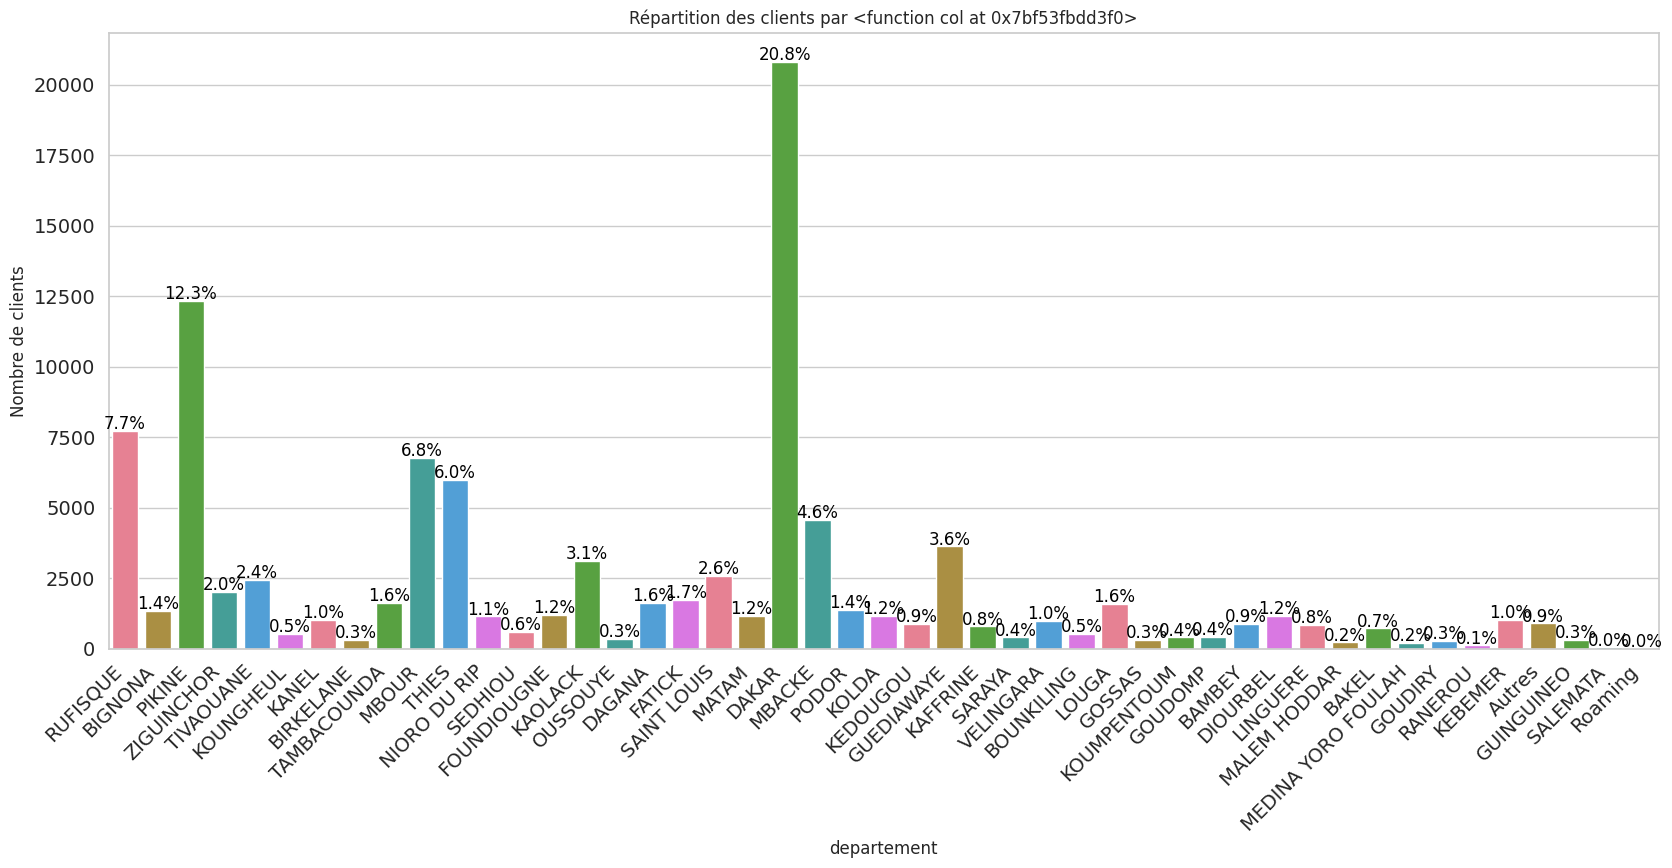

In [ ]:
# Utilisation de la fonction avec les variables nécessaires
plot_colonne_distribution(pd_localisation, "departement")

In [ ]:
import pandas as pd

def pourcentage_clients_par_colonne(dataframe, territoire):
    # Groupez le DataFrame par la colonne spécifiée et comptez le nombre de clients dans chaque région.
    territoire_counts = dataframe[territoire].value_counts()

    # Calculez le pourcentage de clients par région en divisant le nombre de clients dans chaque région par le nombre total de clients.
    total_clients = len(dataframe)
    region_percentages = (territoire_counts / total_clients) * 100

    # Créez un nouveau DataFrame pour afficher les résultats sous forme de tableau.
    result_df = pd.DataFrame({territoire: region_percentages.index, 'Pourcentage de Clients': region_percentages.values})

    # Triez le DataFrame par pourcentage décroissant.
    result_df = result_df.sort_values(by='Pourcentage de Clients', ascending=False)

    # Formatez la colonne "Pourcentage de Clients" avec le signe '%' et deux chiffres après la virgule.
    result_df['Pourcentage de Clients'] = result_df['Pourcentage de Clients'].apply(lambda x: f'{x:.2f}%')

    # Réinitialisez l'index du DataFrame résultant.
    result_df = result_df.reset_index(drop=True)

    return result_df

resultat = pourcentage_clients_par_colonne(pd_localisation, 'commune_arrondissement')
pd.set_option('display.max_rows', None)
resultat


,commune_arrondissement,Pourcentage de Clients
0,PARCELLES ASSAINIES,6.41%
1,NIAYES,4.94%
2,ALMADIES,4.93%
3,GRAND DAKAR,4.77%
4,DAKAR PLATEAU,4.69%
5,THIAROYE,4.11%
6,NDAME,3.94%
7,THIES,3.90%
8,GUEDIAWAYE,3.63%
9,PIKINE DAGOUDANE,3.28%


In [ ]:
ville_set=collect_set(df_localisation["ca_cr_commune"]).alias("villes")

df_location = df_localisation.groupBy("msisdn").agg(ville_set, size(ville_set).alias("nombre_villes"))
df_location.show()

+-------+--------------------+-------------+
| msisdn|              villes|nombre_villes|
+-------+--------------------+-------------+
| 100006|      [PIKINE OUEST]|            1|
|1000067|        [THIES NORD]|            1|
| 100010|[MERMOZ-SACRE COEUR]|            1|
|1000101|[FANN POINT E AMI...|            1|
|1000122| [MBOUR, MALICOUNDA]|            2|
|1000145|          [KATHIOTE]|            1|
|1000214|[DIAXAY PARCELLE ...|            1|
|1000315|           [DIAWARA]|            1|
|1000355|        [DEMBANCANE]|            1|
| 100046|             [MBOUR]|            1|
|1000554|  [THIAROYE SUR MER]|            1|
|1000585|       [BISCUITERIE]|            1|
|1000639|          [MBEDIENE]|            1|
| 100070|[FANN POINT E AMI...|            2|
|1000743|            [SOMONE]|            1|
|1000745|             [DAHRA]|            1|
|1000747|      [VELINGARA_KD]|            1|
|1000780|              [MBAO]|            1|
|1000814|             [MBOUR]|            1|
|1000973| 

## **Prétraitement des données**

### Transformation des données

In [9]:
def df_transform(df: DataFrame):
    # Transformation en minuscule de la colonne Type transaction
    df = df.withColumn("typetransaction", lower(df["typetransaction"]))

    # Sélection des Colonnes Nécessaires
    no_taken_columns = ["fees", "operation", "date",  "ingest_date", "description", "status", "statuscode"]
    taken_columns = ["transactionid", "msisdn", "destinataire", "montant","year", "month", "day","typetransaction", "titre",  "channel", "statuscode"]
    df = df.select(taken_columns)

    # Sélection des colonnes nécessaires et renommage
    df = df.select(taken_columns) \
        .withColumnRenamed("msisdn", "numero") \
        .withColumnRenamed("day", "date") \
        .withColumnRenamed("titre", "type_service")

    # Supprimer les lignes où 'Montant' est égal à "NULL"
    df = df.filter(df["montant"] != "NULL")

    # Conversion des données des colonnes Date et Montant
    df = df.withColumn("montant", df["montant"].cast(FloatType()))
    df = df.withColumn("date", to_date(df["date"], "yyyyMMdd"))

     # Données manquantes et standardisation sur la colonne TypesTransaction
    df = df.withColumn("type_service",
                      when((df["typetransaction"] == "cashin") & (df["type_service"] == "NULL"), "Depot")
                      .when((df["typetransaction"] == "cashin") & (df["type_service"] == "Dépot"), "Depot")
                      .when((df["typetransaction"] == "achat_credit") & (df["type_service"] == "Recharge Crédit"), "Recharge Credit")
                      .when((df["typetransaction"] == "cashout") & (df["type_service"] == "NULL"), "Retrait")
                      .when((df["typetransaction"] == "transfert") & (df["type_service"] == "NULL"), "Transfert")
                      .when((df["typetransaction"] == "cashinother") & (df["type_service"] == "NULL"), "Autre retrait")
                      .when((df["typetransaction"] == "cashout_confirm") | (df["typetransaction"] == "cashout") & (df["type_service"] == "Retrait d'argent"), "Retrait")
                      .when((df["typetransaction"] == "paiement_marchand") & (df["type_service"] == "NULL"), "Paiement marchand")
                      .otherwise(df["type_service"])
                      )
     # Définissez le dictionnaire de services
    services = {
        'service_financier': ["OM vers Banque", "Retrait avec code", "Retrait", "Banque vers OM", "Depot", "Envoi", "Transfert international", "Autre retrait", "Transfert"],
        'paiement': ["Rapido", "Paiement marchand", "Ubipharm", "Sunna Moon", "Canal +", "SEN'EAU", "AQUATECH", "ISM", "Carte TotalEnergies", "SONATELFIXE", "SDE", "Woyofal", "SONATELMOBILE", "SEN", "Recharge Xeweul", "SAMA MBEY", "ILEMEL"],
        'achat': ["Recharge Credit", "Pass Illimix", "Pass Internet", "Vente Crédit"],
        'don_cotisation': ["Dons et cotisations"]
    }
    df_transformed= df.withColumn("categorie_service",df["type_service"])
    # Utilisez la fonction `withColumn` pour ajouter la colonne "type_service" en fonction des catégories
    for categorie, liste_services in services.items():
        df_transformed = df_transformed.withColumn("categorie_service", when(df_transformed["categorie_service"].isin(liste_services), categorie).otherwise(df_transformed["categorie_service"]))


    return df_transformed

### Nettoyage des données

In [10]:
def df_clean(df):

    # Données manquantes sur la colonne channel
    df = df.withColumn("channel", when(df["channel"] == "NULL", "Inconnu").otherwise(df["channel"]))

    # Transactions échoué
    status_success =["200","TS","éffectué"]
    status_failed = ["échoué", "TP", "TF"]

    # Utilisez la fonction "when" pour créer une colonne "reussi"
    df = df.withColumn("statuscode", when(col("statuscode").isin(status_success), "réussi").otherwise("non réussi"))
    # Filtrer les lignes où le statut est "réussi"
    df_reussi = df.filter(col("statuscode") == "réussi")

    # Gestion des données aberrantes
    df = df.filter(df["montant"] >0)
    df = df.filter(df["montant"] <2000000)
    # Gestion des données dupliquées
    df_cleaned = df.dropDuplicates()
    return df_cleaned


###Structuration des données

In [11]:
#Définition des dataframes préparés
df_transformed=df_transform(df_transaction_om)
df_transaction_prepared=df_clean(df_transformed)
df_transaction_prepared.printSchema()

root
 |-- transactionid: string (nullable = true)
 |-- numero: string (nullable = true)
 |-- destinataire: string (nullable = true)
 |-- montant: float (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- date: date (nullable = true)
 |-- typetransaction: string (nullable = true)
 |-- type_service: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- statuscode: string (nullable = false)
 |-- categorie_service: string (nullable = true)



In [12]:
df_info(df_transaction_prepared)

root
 |-- transactionid: string (nullable = true)
 |-- numero: string (nullable = true)
 |-- destinataire: string (nullable = true)
 |-- montant: float (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- date: date (nullable = true)
 |-- typetransaction: string (nullable = true)
 |-- type_service: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- statuscode: string (nullable = false)
 |-- categorie_service: string (nullable = true)

['transactionid', 'numero', 'destinataire', 'montant', 'year', 'month', 'date', 'typetransaction', 'type_service', 'channel', 'statuscode', 'categorie_service']

 
  Nombre de lignes : 1983572, Nombre de colonnes : 12
+----------------------------------------------------------------+-------+----------------------------------------------------------------+-------+----+-----+----------+-------------------+---------------+-------------+----------+-----------------+
|transactionid                   

###Sauvegarde des données

In [ ]:
def df_save(df: DataFrame, pathForSave) :
  df_saved=df.toPandas().to_csv(pathForSave, index=False)
  return df_saved

df_saved=df_save(df_transaction_prepared, '#datasets_OM/base_transaction_om_prepared.csv')

In [ ]:
pd_transaction_prepared=pd.read_csv('#datasets_OM/base_transaction_om_prepared.csv')
pd_transaction_prepared.info()

### Visualisations

In [ ]:
df_info_detailed(df_transaction_prepared)

root
 |-- transactionid: string (nullable = true)
 |-- numero: string (nullable = true)
 |-- destinataire: string (nullable = true)
 |-- montant: float (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- date: date (nullable = true)
 |-- typetransaction: string (nullable = true)
 |-- type_service: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- statuscode: string (nullable = false)

['transactionid', 'numero', 'destinataire', 'montant', 'year', 'month', 'date', 'typetransaction', 'type_service', 'channel', 'statuscode']

 
  Nombre de lignes : 1983572, Nombre de colonnes : 11
+----------------------------------------------------------------+-------+----------------------------------------------------------------+-------+----+-----+----------+---------------+------------+-------------+----------+
|transactionid                                                   |numero |destinataire                                          

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Supposons que vous ayez un DataFrame Pandas 'pd_transaction_om' avec les données
pd_transaction_om=pd_transaction_om
# Créez une figure avec des sous-graphiques
fig, axes = plt.subplots(2, 1, figsize=(10, 18))


# Sous-graphique 1 : Distribution des Titres
titre_counts = pd_transaction_om['TitreY'].value_counts()
axes[0].bar(titre_counts.index, titre_counts.values, color='lightcoral')
axes[0].set_title('Distribution des Titres')
axes[0].set_xlabel('Titre')
axes[0].set_ylabel('Fréquence')
axes[0].tick_params(axis='x', rotation=45)

# Sous-graphique 2 : Distribution des Canaux
channel_counts = pd_transaction_om['channel'].value_counts()
axes[1].bar(channel_counts.index, channel_counts.values, color='lightblue')
axes[1].set_title('Distribution des Canaux')
axes[1].set_xlabel('Canal')
axes[1].set_ylabel('Fréquence')
axes[1].tick_params(axis='x', rotation=45)


# # Sous-graphique 1 : Distribution des montants (Intervalles de 10,000)
# montants = pd_transaction_om['montant'].astype(float)
# bins = range(0, int(montants.max()) + 10000, 10000)
# hist, edges = np.histogram(montants, bins=bins)
# axes[2].hist(montants, bins=bins, color='skyblue', edgecolor='black')
# axes[2].set_xticks(edges)
# axes[2].set_xticklabels([f'{edges[i]:,.0f}-{edges[i+1]:,.0f}' for i in range(len(edges) - 1)])
# axes[2].set_title('Distribution des montants (Intervalles de 10,000)')
# axes[2].set_xlabel('montant')
# axes[2].set_ylabel('Fréquence')


# Ajustez l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichez les sous-graphiques
plt.show()


# **MODÉLISATION POUR LA SEGMENTATION MULTISERVICE**

---



### Méthode

In [15]:
def segmenter_multiservice(df: DataFrame):
    # Groupement par client (Numéro) et collecte des types de transactions uniques et des canaux uniques
    channel_set = collect_set(df["channel"]).alias("canaux")
    service_set=collect_set(df["type_service"]).alias("services")
    categorie_set=collect_set(df["categorie_service"]).alias("categories_services")
    multiservice_segmentation = df.groupBy("numero").agg(
        service_set,
        size(service_set).alias("nombre_services"),
        categorie_set,
        size(categorie_set).alias("nombre_categories"),
        channel_set,
        size(channel_set).alias("nombre_canaux"),
        sum("montant").alias("montant_total")

    )

    # Définir la valeur du seuil
    seuil = 1
    # Calcul du segment
    multiservice_segmentation = multiservice_segmentation.withColumn("segment_service", when(multiservice_segmentation["nombre_services"] <= seuil, "Monoservice").otherwise("Multiservice"))
    multiservice_segmentation = multiservice_segmentation.withColumn("segment_categorie", when(multiservice_segmentation["nombre_categories"] <= seuil, "Monocategorie").otherwise("Multicategorie"))
    return multiservice_segmentation


# Appeler la fonction pour calculer la segmentation des clientsd
df_segment_multiservice = segmenter_multiservice(df_transaction_prepared)
pd_segment_multiservice=df_segment_multiservice.toPandas()
# # Afficher le résultat
df_segment_multiservice.printSchema()

root
 |-- numero: string (nullable = true)
 |-- services: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- nombre_services: integer (nullable = false)
 |-- categories_services: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- nombre_categories: integer (nullable = false)
 |-- canaux: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- nombre_canaux: integer (nullable = false)
 |-- montant_total: double (nullable = true)
 |-- segment_service: string (nullable = false)
 |-- segment_categorie: string (nullable = false)



In [ ]:
pd_segment_multiservice.to_csv('#datasets_OM/segments_multiservice.csv', index=False)

In [ ]:
def profil_client_multiservice(numero):
    # Calcul de la segmentation multiservice pour l'ensemble des clients
    # profil_client_multiservice = segmenter_multiservice(df_transaction_prepared)
    profil_client = df_segment_multiservice
    # Filtrage du profil du client en fonction du numéro donné
    profil_client = profil_client.filter(profil_client["numero"] == numero).collect()
    # Conversion du profil du client en dictionnaire et collecte du résultat
    profil_client = [row.asDict() for row in profil_client]

    # Retourne le premier (et unique) élément du résultat, qui est un dictionnaire
    return profil_client


In [ ]:
# Appel de la fonction pour obtenir le profil du client
profil_client_multiservice(numero=1000339)

[{'numero': '1000339',
  'services': ['Retrait', 'Transfert'],
  'nombre_services': 2,
  'canaux': ['USSD'],
  'nombre_canaux': 1,
  'montant': 32050.0,
  'segment_service': 'Multiservice'}]

### Visualisations

In [ ]:
import pandas as pd

# Supposons que vous avez déjà un DataFrame pd_rfm_segments
# Vous pouvez l'initialiser comme suit
# pd_rfm_segments = pd.read_csv('votre_fichier.csv')

# Groupement par segment_RFM et calcul des statistiques pour chaque groupe
segment_stats = pd_segment_multiservice.groupby('segment_service').agg({
    'numero': 'count',  # Nombre de clients
    'nombre_services': ['min', 'max', 'mean'],  # Min, max et moyenne du nombre de services
    'montant': ['min', 'max', 'mean']  # Min, max et moyenne du chiffre d'affaires
})

# Renommer les colonnes pour plus de clarté
segment_stats.columns = ['Nombre_clients',
                         'Nb_services_min', 'Nb_services_max', 'Nb_services_moy',
                         'CA_min', 'CA_max', 'CA_moy']

# Calculer le pourcentage des clients et le convertir en pourcentage (avec deux chiffres après la virgule)
total_clients = segment_stats['Nombre_clients'].sum()
segment_stats['%Clients'] = (segment_stats['Nombre_clients'] / total_clients * 100).apply(lambda x: f'{x:.2f} %')
segment_stats = segment_stats.drop('Nombre_clients', axis=1)  # Supprimer la colonne Nombre_clients

# Définir une fonction pour formater avec un espace comme séparateur des milliers
def format_with_space(value):
    return f"{value:,.0f}".replace(",", " ")

# Appliquer la fonction de formatage aux colonnes appropriées
formatted_segment_stats = segment_stats.copy()
formatted_segment_stats = formatted_segment_stats.applymap(lambda x: format_with_space(x) if isinstance(x, (int, float)) else x)

# Utiliser Styler.format pour afficher le DataFrame avec le format des milliers
formatted_segment_stats.style.format(formatter=None)


,Nb_services_min,Nb_services_max,Nb_services_moy,CA_min,CA_max,CA_moy,%Clients
segment_service,,,,,,,
Monoservice,1,1,1,1,72 746 577,33 209,54.44 %
Multiservice,2,11,3,20,152 273 784,314 406,45.56 %


In [ ]:
pd_segment_multiservice

,numero,services,nombre_services,categories_services,nombre_categories,canaux,nombre_canaux,montant,segment_service
0,1000000,"[Pass Illimix, SONATELFIXE, Transfert]",3,"[paiement, achat, service_financier]",3,[mobile],1,68500.0,Multiservice
1,1000001,"[Retrait, Recharge Credit, Transfert]",3,"[achat, service_financier]",2,"[mobile, USSD]",2,40650.0,Multiservice
2,1000038,"[Retrait, Woyofal]",2,"[paiement, service_financier]",2,"[mobile, USSD]",2,6500.0,Multiservice
3,1000048,"[Retrait, Recharge Credit, Transfert]",3,"[achat, service_financier]",2,[USSD],1,105000.0,Multiservice
4,1000054,[Retrait],1,[service_financier],1,[USSD],1,7000.0,Monoservice
...,...,...,...,...,...,...,...,...,...
268164,999876,[],0,[],0,[USSD],1,7050.0,Monoservice
268165,999884,[Recharge Credit],1,[achat],1,[USSD],1,500.0,Monoservice
268166,999885,[Retrait],1,[service_financier],1,[USSD],1,9000.0,Monoservice
268167,999898,"[Retrait, Transfert]",2,[service_financier],1,"[mobile, USSD]",2,182500.0,Multiservice


In [ ]:
df_pre=pd_transaction_prepared[["numero","typetransaction", "type_service", "channel" ,"statuscode"]].rename(columns={"statuscode":"Status_code"})
df_transaction_prepared.select("type_service").withColumnRenamed("type_service","Service").distinct().toPandas()

,Service
0,OM vers Banque
1,Rapido
2,Recharge Credit
3,SEN
4,Pass Illimix
5,Transfert
6,Recharge Xeweul
7,SAMA MBEY
8,ILEMEL
9,Retrait avec code


In [ ]:
df_info(df_segment_multiservice)

root
 |-- Numero: string (nullable = true)
 |-- Services: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- Nombre_services: integer (nullable = false)
 |-- Canaux: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- Nombre_canaux: integer (nullable = false)
 |-- Segment_service: string (nullable = false)

['Numero', 'Services', 'Nombre_services', 'Canaux', 'Nombre_canaux', 'Segment_service']

 
  Nombre de lignes : 263532, Nombre de colonnes : 6
+-------+--------------------------------------+---------------+--------------+-------------+---------------+
|Numero |Services                              |Nombre_services|Canaux        |Nombre_canaux|Segment_service|
+-------+--------------------------------------+---------------+--------------+-------------+---------------+
|1000000|[Pass Illimix, SONATELFIXE, Transfert]|3              |[mobile]      |1            |Multiservice   |
|1000001|[Retrait, Recharge Credit, Transfert] |3    

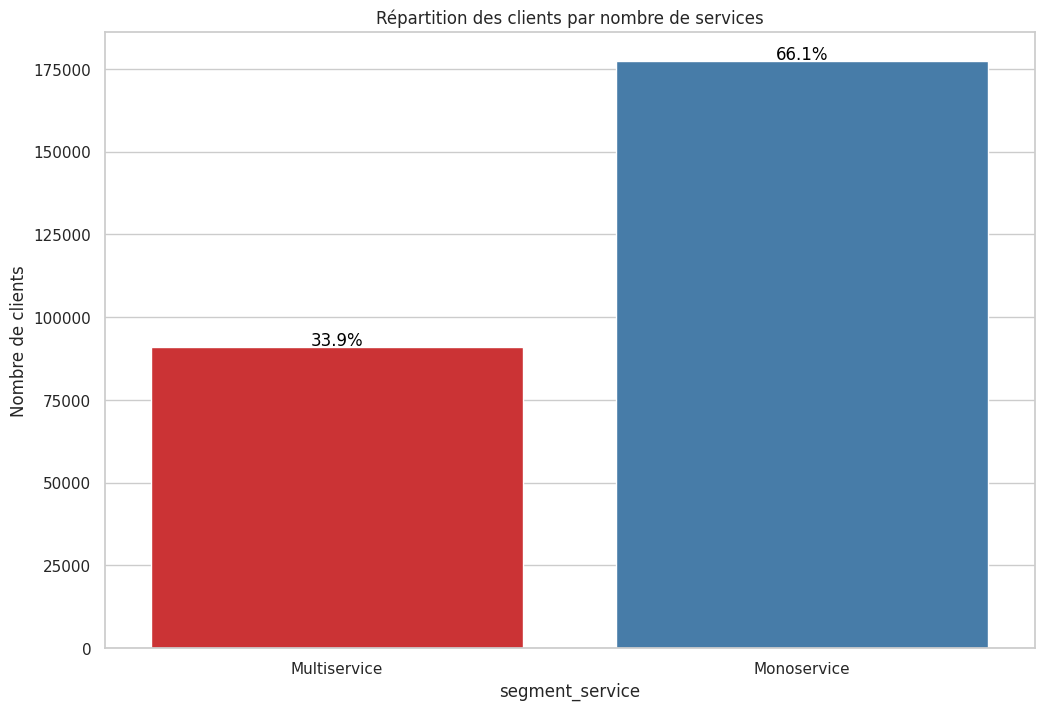

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créez un countplot avec une palette de couleurs personnalisée
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.set(style="whitegrid")

custom_palette = sns.color_palette("Set1")

sns.countplot(x="segment_service", data=pd_segment_multiservice, palette=custom_palette)

# Calculez le nombre total de clients
total_count = len(pd_segment_multiservice)

# Annoter les barres avec des pourcentages
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Modifier l'étiquette de l'axe des ordonnées et le titre
ax.set_ylabel('Nombre de clients')
ax.set_title('Répartition des clients par nombre de services')

plt.show()


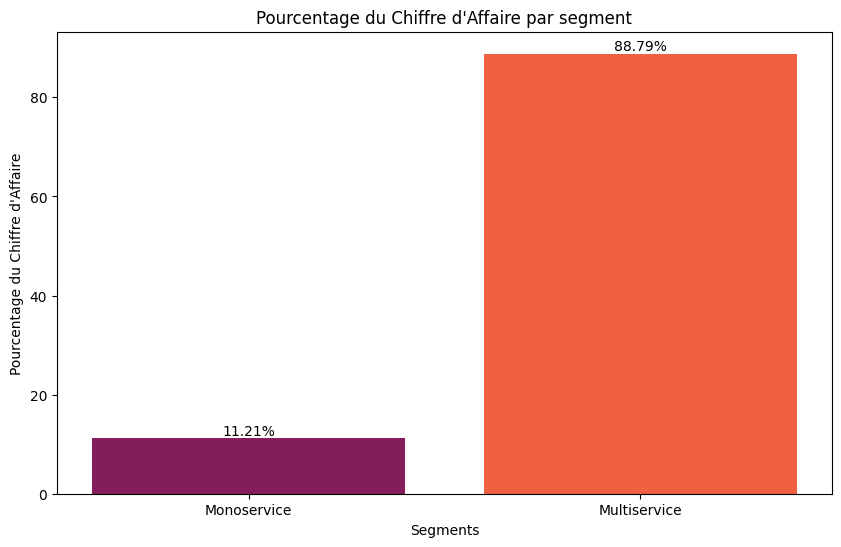

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir le dataframe Spark en un DataFrame Pandas
# Assurez-vous que vous avez déjà initialisé Spark et chargé les données dans pd_segment_multiservice

# Regroupez par le nombre de services et calculez le chiffre d'affaires total
service_grouped = pd_segment_multiservice.groupby('Segment_service')['montant'].sum().reset_index()

# Calculez le pourcentage du chiffre d'affaires pour chaque nombre de services
total_montant = service_grouped['montant'].sum()
service_grouped['Pourcentage_montant'] = (service_grouped['montant'] / total_montant) * 100

# Créez une palette de couleurs diversifiée
diverse_palette = sns.color_palette("rocket", n_colors=len(service_grouped))

# Créez un graphique à barres en utilisant la palette de couleurs diversifiée
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(service_grouped.index, service_grouped['Pourcentage_montant'], color=diverse_palette)
ax.set_xlabel('Segments')
ax.set_ylabel('Pourcentage du Chiffre d\'Affaire')
ax.set_title('Pourcentage du Chiffre d\'Affaire par segment')

# Personnalisez les étiquettes de l'axe des abscisses
ax.set_xticks(service_grouped.index)
ax.set_xticklabels(service_grouped['Segment_service'])

# Annoter les barres avec les pourcentages
for i, percentage in enumerate(service_grouped['Pourcentage_montant']):
    ax.annotate(f'{percentage:.2f}%', (service_grouped.index[i], percentage), ha='center', va='bottom')

plt.show()


# **MODÉLISATION POUR LA SEGMENTATION VALEUR RFM**

---



### Feature engineering

In [ ]:
latest_date = to_date(lit("2023/08/17"), 'yyyy/MM/dd')
def df_rfm_prepare(df):
    # Sélection des colonnes pertinentes pour RFM : numero, montant, date
    df_rfm = df.select("numero", "montant", "date")

    # Calcul de la date maximale dans le DataFrame
    max_date = df_rfm.agg(max("date").alias("max_date")).collect()[0]["max_date"]

    # Convert the max_date string to a date object
    # latest_date = datetime.strptime(max_date, '%Y-%m-%d')

    # Calcul de la récence (Recency)
    df_recency = df_rfm.groupBy("numero").agg(
        datediff(lit(latest_date), max(df["date"])).alias("recence")
    )

    # Calcul de la fréquence (Frequency, le nombre de transactions)
    df_frequency = df_rfm.groupBy("numero").agg(
        count("*").alias("frequence")
    )

    # Calcul de la valeur monétaire (Monetary Value, montant total des transactions)
    df_monetary = df_rfm.groupBy("numero").agg(
        sum("montant").alias("montant")
    )

    # Jointure des DataFrames Recency, Frequency et Monetary
    df_rfm = df_recency.join(df_frequency, "numero", "inner").join(df_monetary, "numero", "inner")

    return df_rfm

In [ ]:
df_rfm_prepared=df_rfm_prepare(df_transaction_prepared)
# pd_rfm_segments_prepared=df_rfm_prepared.toPandas()

### Calcul des scores

In [ ]:
def calculer_scores_rfm(df_rfm):
    # Calculer les quantiles pour les caractéristiques recence, frequence et montant
    quantiles = df_rfm.approxQuantile(["recence", "frequence", "montant"], [0.2, 0.4, 0.6, 0.8], 0.01)

    # Définir des expressions conditionnelles pour attribuer les scores R, F, et M
    df_rfm = (df_rfm
        .withColumn("score_R",  when(df_rfm["recence"] <= quantiles[0][0], lit(5))
                                .when(df_rfm["recence"] <= quantiles[0][1], lit(4))
                                .when(df_rfm["recence"] <= quantiles[0][2], lit(3))
                                .when(df_rfm["recence"] <= quantiles[0][3], lit(2))
                                .otherwise(lit(1)))
        .withColumn("score_F", when(df_rfm["frequence"] >= quantiles[1][3], lit(5))
                                .when(df_rfm["frequence"] >= quantiles[1][2], lit(4))
                                .when(df_rfm["frequence"] >= quantiles[1][1], lit(3))
                                .when(df_rfm["frequence"] >= quantiles[1][0], lit(2))
                                .otherwise(lit(1)))
        .withColumn("score_M", when(df_rfm["montant"] >= quantiles[2][3], lit(5))
                                .when(df_rfm["montant"] >= quantiles[2][2], lit(4))
                                .when(df_rfm["montant"] >= quantiles[2][1], lit(3))
                                .when(df_rfm["montant"] >= quantiles[2][0], lit(2))
                                .otherwise(lit(1)))
                )
    df_rfm=df_rfm.withColumn("score_RFM", concat(df_rfm["score_R"].cast(StringType()), df_rfm["score_F"].cast(StringType()), df_rfm["score_M"].cast(StringType())))
    return df_rfm


### Profilage des segments

In [ ]:
def profiler_segments_rfm(df_rfm):
    segments = {
        'Champion': ['555', '554', '544', '545', '454', '455', '445'],
        'Fidèle': ['543', '444', '435', '355', '354', '345', '344', '335'],
        'Fidèle potentiel': [
            '553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442',
            '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'
        ],
        'Prometteur': [
            '525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414',
            '415', '315', '314', '313'
        ],
        'À surveiller': ['535', '534', '443', '434', '343', '334', '325', '324'],
        'À risque': [
            '255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224',
            '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'
        ],
        'En sommeil': [
            '332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'
        ],
        'Sur le point de dormir': [
            '331', '321', '312', '221', '213', '231', '241', '251'
        ],
        # 'Engagés en sommeil': ["111", "112", "121", "131", "141", "151"],
        'Perdu': ['111', '112', '121', '131', '141', '151'],
        'Nouveau': ['512', '511', '422', '421', '412', '411', '311']
    }

    # Utiliser une expression conditionnelle pour attribuer les segments en fonction des scores RFM
    df_rfm = (df_rfm
        .withColumn('segment_RFM',
            when(df_rfm['score_RFM'].isin(segments['Champion']), lit('Champion'))
            .when(df_rfm['score_RFM'].isin(segments['Fidèle']), lit('Fidèle'))
            .when(df_rfm['score_RFM'].isin(segments['Fidèle potentiel']), lit('Fidèle potentiel'))
            .when(df_rfm['score_RFM'].isin(segments['Nouveau']), lit('Nouveau'))
            .when(df_rfm['score_RFM'].isin(segments['Prometteur']), lit('Prometteur'))
            .when(df_rfm['score_RFM'].isin(segments['À surveiller']), lit('À surveiller'))
            .when(df_rfm['score_RFM'].isin(segments['À risque']), lit('À risque'))
            .when(df_rfm['score_RFM'].isin(segments['Sur le point de dormir']), lit('Sur le point de dormir'))
            .when(df_rfm['score_RFM'].isin(segments['En sommeil']), lit('En sommeil'))
            # .when(df_rfm['score_RFM'].isin(segments['Engagés en sommeil']), lit('Engagés en sommeil'))
            .when(df_rfm['score_RFM'].isin(segments['Perdu']), lit('Perdu'))
            .otherwise(lit('Autre'))
        )
    )

    return df_rfm


### Test de la méthode RFM

In [ ]:
def segmenter_valeur_rfm(dataFrame: DataFrame):
  # df_transformed=df_transform(dataFrame)
  # df_transaction_prepared=df_clean(df_transformed)
  df_rfm=df_rfm_prepare(dataFrame)
  df_rfm_scores= calculer_scores_rfm(df_rfm)
  df_rfm_segments = profiler_segments_rfm(df_rfm_scores)
  return df_rfm_segments


In [ ]:
df_rfm_segments=segmenter_valeur_rfm(df_transaction_prepared)
# df_rfm_segments.show()

In [ ]:
def segment_client_rfm(numero):
  rfm_result=df_rfm_segments.drop("score_R","score_F","score_M").where(df_rfm_segments["numero"]==numero)
  rfm_result=rfm_result.toJSON().collect()[0]
  return  rfm_result

In [ ]:
segment_client_rfm(1000038)

'{"numero":"1000038","recence":123,"frequence":2,"montant":6500.0,"score_RFM":"332","segment_RFM":"En sommeil"}'

### Sauvegarde du DataFrame RFM

In [ ]:
#Save to csv
pd_rfm_segments=df_rfm_segments.toPandas()
pd_rfm_segments_sort =pd_rfm_segments.sort_values(["score_RFM"])

In [ ]:
pd_rfm_segments.to_csv('#datasets_OM/segments_rfm.csv', index=False)
# pd.read_csv('#datasets_OM/base_transaction_om_rfm.csv')

### Exploration du Dataframe RFM

In [ ]:
df_info(df_rfm_segments)

root
 |-- numero: string (nullable = true)
 |-- recence: integer (nullable = true)
 |-- frequence: long (nullable = false)
 |-- montant: double (nullable = true)
 |-- score_R: integer (nullable = false)
 |-- score_F: integer (nullable = false)
 |-- score_M: integer (nullable = false)
 |-- score_RFM: string (nullable = false)
 |-- segment_RFM: string (nullable = false)

['numero', 'recence', 'frequence', 'montant', 'score_R', 'score_F', 'score_M', 'score_RFM', 'segment_RFM']

 
  Nombre de lignes : 268169, Nombre de colonnes : 9
+-------+-------+---------+--------+-------+-------+-------+---------+-----------+
|numero |recence|frequence|montant |score_R|score_F|score_M|score_RFM|segment_RFM|
+-------+-------+---------+--------+-------+-------+-------+---------+-----------+
|1000000|167    |5        |68500.0 |3      |4      |5      |345      |Fidèle     |
|1000001|92     |6        |40650.0 |3      |5      |4      |354      |Fidèle     |
|1000038|123    |2        |6500.0  |3      |3      

In [ ]:
taken_columns_sico = [ 'nd', 'date_naissance', 'date_debut_engagement', 'statut']
df_sic = df_sico.select(taken_columns_sico) \
          .filter(df_sico["statut"]=="ACTIF")  \
          .filter(df_sico["date_naissance"] != "NULL")\
          .withColumnRenamed("nd", "numero") \
          .drop("statut")

df_sic= df_sic.withColumn("anciennete",  year(current_date()) - year("date_debut_engagement"))\
        .withColumn("age", year(current_date()) - year("date_naissance")).drop("date_naissance")\
        .filter(col("age")>15) \
        .filter(col("age")<90) \
        .drop("date_debut_engagement")


# ville_set=collect_set(df_localisation["ca_cr_commune"]).alias("villes")
# df_loc=df_localisation.select("msisdn","ca_cr_commune") \
#                       .groupBy("msisdn").agg(ville_set, size(ville_set).alias("nombre_villes"))\
#                       .withColumnRenamed("msisdn","numero")

df_rfm_joined=df_rfm_segments.drop('score_R','score_F','score_M').join(df_sic,'numero', 'inner')
pd_rfm_joined= df_rfm_joined.toPandas()

In [ ]:
df_rfm_joined.printSchema()

root
 |-- numero: string (nullable = true)
 |-- recence: integer (nullable = true)
 |-- frequence: long (nullable = false)
 |-- montant: double (nullable = true)
 |-- score_RFM: string (nullable = false)
 |-- segment_RFM: string (nullable = false)
 |-- anciennete: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- villes: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- nombre_villes: integer (nullable = false)



In [ ]:
pd_rfm_joined.describe()

,recence,frequence,montant,anciennete,age
count,25738.000000,25738.000000,2.573800e+04,25738.000000,25738.000000
mean,155.532170,5.559834,1.049958e+05,9.258373,38.881110
std,170.040322,19.291786,4.851064e+05,4.142786,12.555742
min,0.000000,1.000000,1.000000e+00,0.000000,16.000000
25%,11.000000,1.000000,5.200000e+03,6.000000,29.000000
50%,98.000000,3.000000,1.950000e+04,10.000000,36.000000
75%,278.000000,6.000000,6.500000e+04,14.000000,46.000000
max,593.000000,1321.000000,3.287687e+07,15.000000,89.000000


In [ ]:
import pandas as pd

# Define the custom formatting function
def format_with_space(value):
    if isinstance(value, (int, float)):
            return f"{value:,.0f}".replace(",", " ")
    return value

# Select the specific columns and calculate the default summary
selected_columns = ["numero", "recence", "frequence", "montant"]
summary = pd_rfm_segments[selected_columns].describe()

# Apply custom formatting to the summary
formatted_summary = summary.applymap(lambda x: format_with_space(x) if isinstance(x, (int, float)) else x)

# Print the formatted summary
formatted_summary


,Recence,Frequence,Montant
count,263 532,263 532,263 532
mean,174,7,161 330
std,175,44,1 351 968
min,0,1,1
25%,13,1,4 500
50%,121,2,14 200
75%,308,5,48 900
max,593,2 452,152 308 784


In [ ]:
import pandas as pd

# Supposons que vous avez déjà un DataFrame pd_rfm_segments
# Vous pouvez l'initialiser comme suit
# pd_rfm_segments = pd.read_csv('votre_fichier.csv')

# Groupement par segment_RFM et calcul des statistiques pour chaque groupe
segment_stats = pd_rfm_segments.groupby('segment_RFM').agg({
    'numero': 'count',  # Nombre de clients
    'recence': ['min', 'max', 'mean'],  # Min, max et moyenne de recence
    'frequence': ['min', 'max', 'mean'],  # Min, max et moyenne de Fréquence
    'montant': ['min', 'max', 'mean']  # Min, max et moyenne de montant
})

# Renommer les colonnes pour plus de clarté
segment_stats.columns = ['Nombre_clients', 'R_min', 'R_max', 'R_moy',
                         'F_min', 'F_max', 'F_moy',
                         'M_min', 'M_max', 'M_moy']

# Calculer le pourcentage des clients et le convertir en pourcentage (avec deux chiffres après la virgule)
total_clients = segment_stats['Nombre_clients'].sum()
segment_stats['%Clients'] = (segment_stats['Nombre_clients'] / total_clients * 100).apply(lambda x: f'{x:.2f} %')
segment_stats = segment_stats.drop('Nombre_clients', axis=1)  # Supprimer la colonne Nombre_clients

# Définir une fonction pour formater avec un espace comme séparateur des milliers
def format_with_space(value):
    return f"{value:,.0f}".replace(",", " ")

# Appliquer la fonction de formatage aux colonnes appropriées
formatted_segment_stats = segment_stats.copy()
formatted_segment_stats = formatted_segment_stats.applymap(lambda x: format_with_space(x) if isinstance(x, (int, float)) else x)

# Utiliser Styler.format pour afficher le DataFrame avec le format des milliers
formatted_segment_stats.style.format(formatter=None)


,R_min,R_max,R_moy,F_min,F_max,F_moy,M_min,M_max,M_moy,%Clients
Segment_RFM,,,,,,,,,,
Autre,350,591,422,3,309,8,22 000,12 148 627,155 388,0.88 %
Champion,0,80,11,3,2 452,27,22 000,152 308 784,704 386,17.63 %
En sommeil,81,593,331,1,2,1,3 000,21 986,7 858,17.76 %
Fidèle,0,168,87,2,1 219,7,9 300,22 201 080,163 271,9.16 %
Fidèle potentiel,0,168,47,1,36,3,2,21 980,9 668,14.62 %
Nouveau,11,80,26,1,1,1,1,9 200,2 518,2.86 %
Perdu,350,593,469,1,7,1,1,2 995,1 402,5.96 %
Prometteur,0,80,8,1,1,1,1,1 990 500,23 597,3.82 %
Sur le point de dormir,81,349,202,1,10,1,1,2 998,1 414,7.17 %


In [ ]:
import pandas as pd

data = {
    'Segment': ['Champions', 'Fidèles', 'Fidèles potentiels', 'A Surveiller', 'Nouveaux', 'Prometteurs',
                'Sur le point de dormir', 'À Risque', 'En sommeil', 'Perdus'],
    'Activité': [
        "Ont récemment acheté, commandent souvent et dépensent le plus.",
        "Passent régulièrement des commandes. Réactifs aux promotions.",
        "Clients récents qui ont dépensé des sommes importantes.",
        "Clients de base dont le dernier achat remonte à plus d'un mois.",
        "Ont acheté très récemment.",
        "Loyalistes potentiels il y a quelques mois. Dépensent fréquemment et une somme importante. Mais le dernier achat remonte à plusieurs semaines.",
        "Ont fait leur dernier achat il y a longtemps, mais au cours des 4 dernières semaines, ils ont soit visité le site soit ouvert un e-mail.",
        "Ont effectué les plus grosses commandes et souvent. Mais ils ne sont pas revenus depuis longtemps.",
        "Clients qui ont fait des achats plus petits et moins fréquents auparavant, mais qui n'ont rien acheté depuis longtemps.",
        "Ont effectué leur dernier achat il y a longtemps et n'ont pas du tout été actifs au cours des 4 dernières semaines."
    ]
}

df = pd.DataFrame(data)

# Centrer le texte dans la colonne 'Activité' et changer la couleur en bleu et blanc
def highlight_text(text):
    return f'text-align: center;'

styled_df = df.style.applymap(highlight_text)

# Add borders between columns
styled_df.set_properties(**{
    'border': '1px solid white',
    'border-collapse': 'collapse',
    'text-align': 'center'
})


,Segment,Activité
0,Champions,"Ont récemment acheté, commandent souvent et dépensent le plus."
1,Fidèles,Passent régulièrement des commandes. Réactifs aux promotions.
2,Fidèles potentiels,Clients récents qui ont dépensé des sommes importantes.
3,A Surveiller,Clients de base dont le dernier achat remonte à plus d'un mois.
4,Nouveaux,Ont acheté très récemment.
5,Prometteurs,Loyalistes potentiels il y a quelques mois. Dépensent fréquemment et une somme importante. Mais le dernier achat remonte à plusieurs semaines.
6,Sur le point de dormir,"Ont fait leur dernier achat il y a longtemps, mais au cours des 4 dernières semaines, ils ont soit visité le site soit ouvert un e-mail."
7,À Risque,Ont effectué les plus grosses commandes et souvent. Mais ils ne sont pas revenus depuis longtemps.
8,En sommeil,"Clients qui ont fait des achats plus petits et moins fréquents auparavant, mais qui n'ont rien acheté depuis longtemps."
9,Perdus,Ont effectué leur dernier achat il y a longtemps et n'ont pas du tout été actifs au cours des 4 dernières semaines.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Given data and segments
data = {
    'Champion': ['555', '554', '544', '545', '454', '455', '445'],
    'Fidèle': ['543', '444', '435', '355', '354', '345', '344', '335'],
    'Fidèle potentiel': [
        '553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442',
        '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'
    ],
    'Prometteur': [
        '525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414',
        '415', '315', '314', '313'
    ],
    'À surveiller': ['535', '534', '443', '434', '343', '334', '325', '324'],
    'À risque': [
        '255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224',
        '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'
    ],
    'En sommeil': [
        '332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'
    ],
    'Sur le point de dormir': [
        '331', '321', '312', '221', '213', '231', '241', '251'
    ],
    'Perdu': ['111', '112', '121', '131', '141', '151'],
    'Nouveau': ['512', '511', '422', '421', '412', '411', '311']
}

# Create a DataFrame with two columns: "segment_RFM" and "score_RFM"
df_segments_scores = None

for segment, scores in data.items():
    segment_df_segments_scores = spark.createDataFrame([(segment, score) for score in scores], ["segment_RFM", "score_RFM"])
    if df_segments_scores is None:
        df_segments_scores = segment_df_segments_scores
    else:
        df_segments_scores = df_segments_scores.union(segment_df_segments_scores)

# Assuming you have a DataFrame called df_segments_scores_rfm_segments
# First, group by the "segment_RFM" column and collect the "RFM_score" values into a list
result_df_segments_scores = df_segments_scores.groupBy("segment_RFM").agg(collect_set("RFM_score").alias("score_RFMs"))

# Show the result DataFrame
result_df_segments_scores.toPandas()


,Segment_RFM,RFM_Scores
0,Champion,"[555, 545, 454, 544, 554, 455, 445]"
1,Fidèle,"[543, 355, 335, 354, 345, 344, 444, 435]"
2,Fidèle potentiel,"[551, 542, 352, 532, 452, 552, 533, 353, 441, ..."
3,Prometteur,"[521, 514, 414, 413, 515, 314, 513, 315, 525, ..."
4,À surveiller,"[443, 334, 434, 535, 343, 325, 324, 534]"
5,À risque,"[224, 244, 235, 242, 143, 134, 142, 254, 234, ..."
6,En sommeil,"[223, 123, 322, 232, 132, 222, 212, 233, 122, ..."
7,Sur le point de dormir,"[331, 231, 213, 221, 312, 321, 251, 241]"
8,Perdu,"[111, 141, 112, 121, 131, 151]"
9,Nouveau,"[311, 421, 512, 511, 412, 411, 422]"


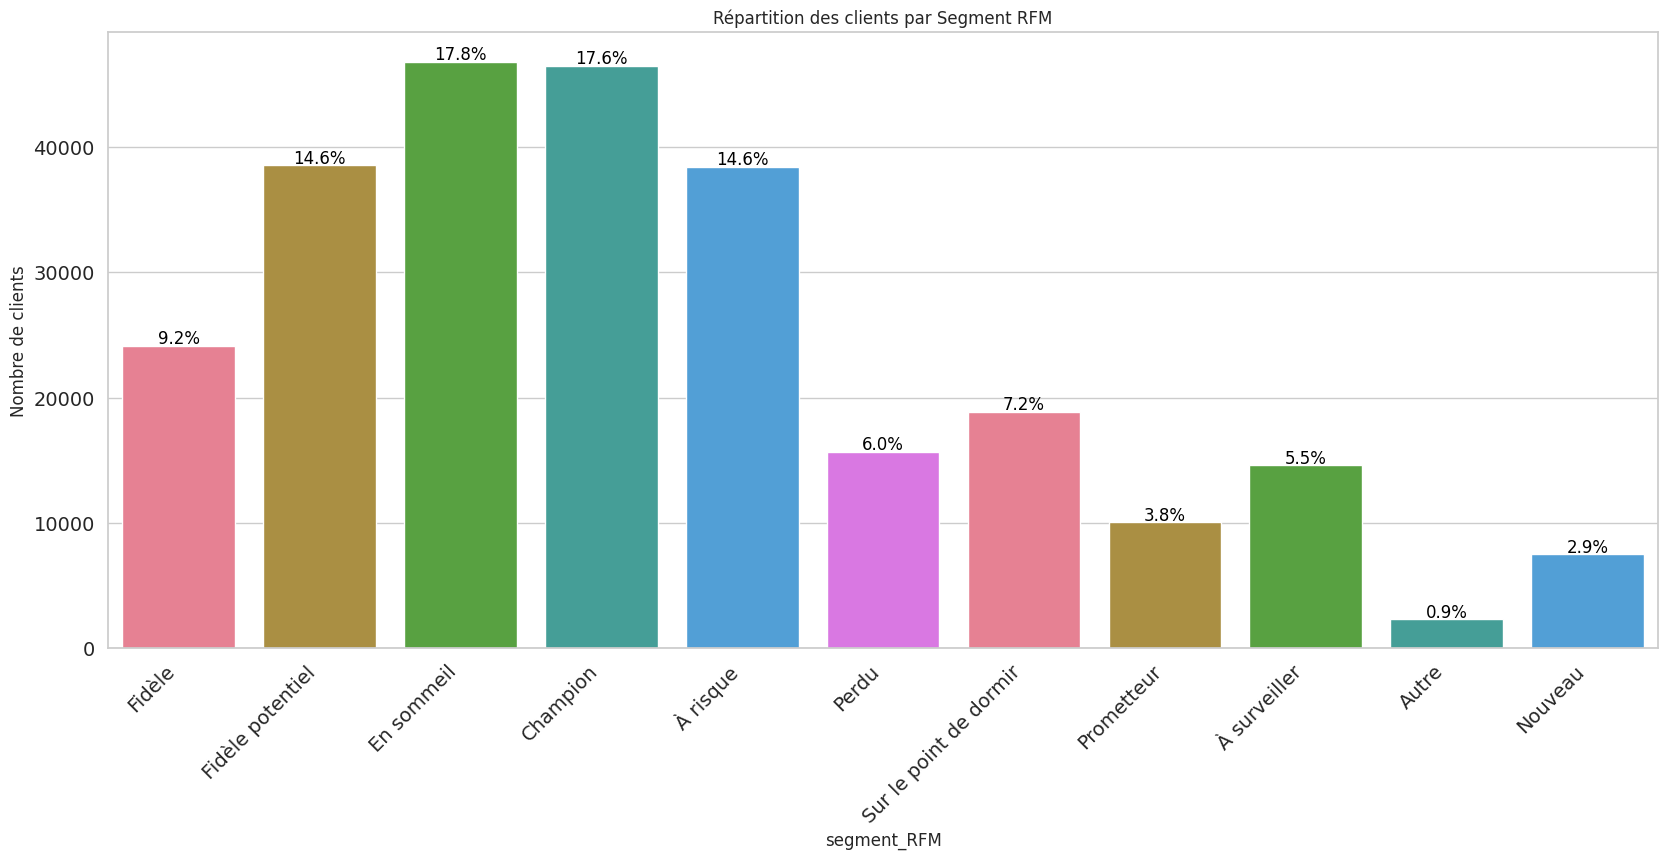

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créez un countplot avec une palette de couleurs personnalisée
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.set(style="whitegrid")

custom_palette = sns.color_palette("husl")

sns.countplot(x="segment_RFM", data=pd_rfm_segments, palette=custom_palette)

# Calculez le nombre total de clients
total_count = len(pd_rfm_segments)

# Annoter les barres avec des pourcentages
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Modifier l'étiquette de l'axe des ordonnées et le titre
ax.set_ylabel('Nombre de clients')
ax.set_title('Répartition des clients par Segment RFM')

# Rotation des étiquettes de l'axe des abscisses de 45 degrés
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Augmenter la taille de la police
ax.tick_params(axis='both', labelsize=14)

plt.show()


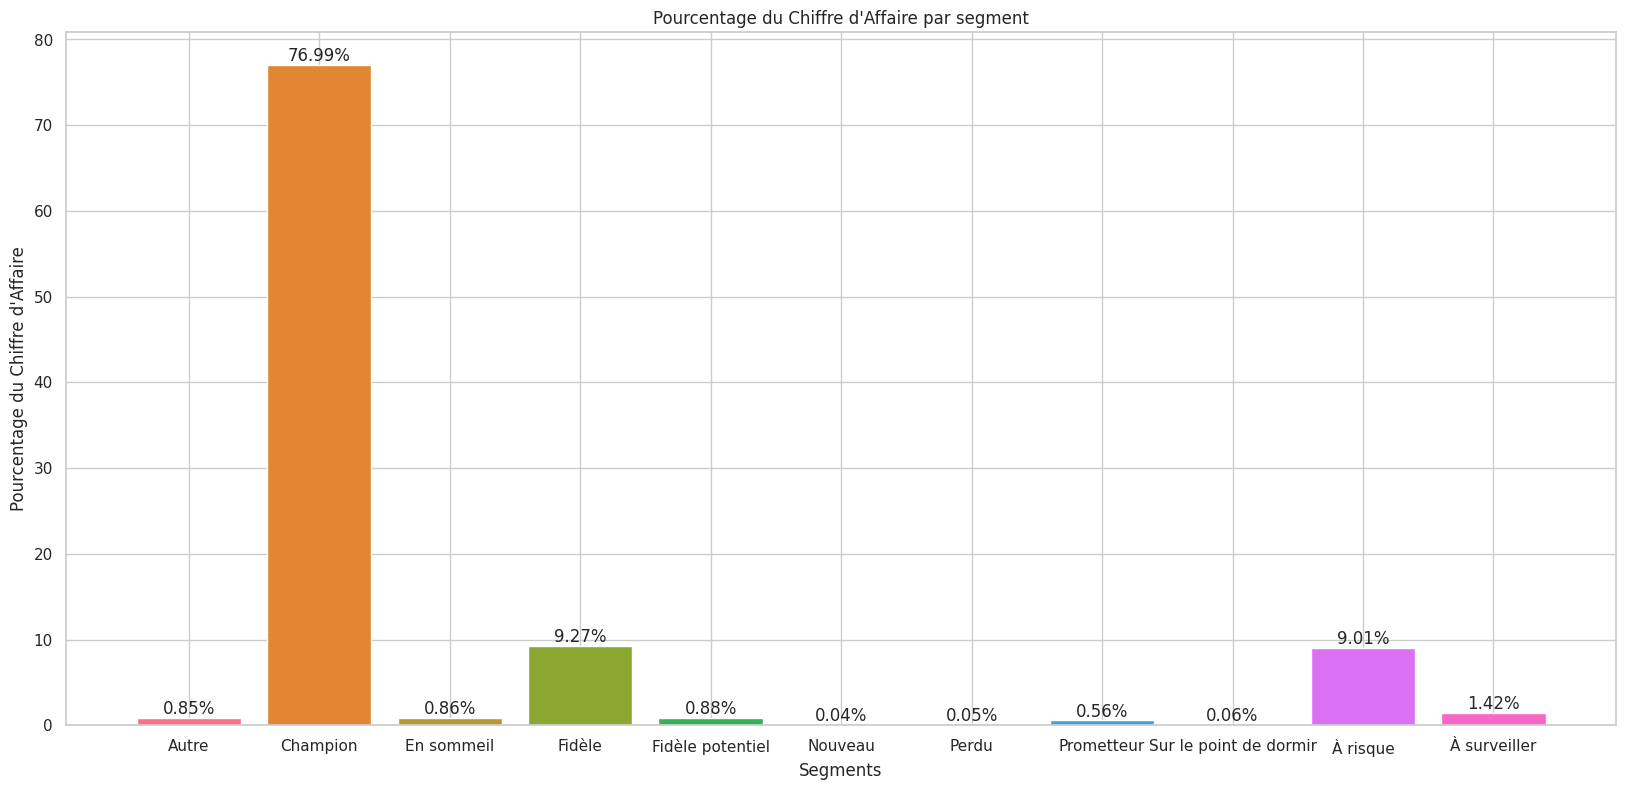

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Regroupez par le nombre de services et calculez le chiffre d'affaires total
service_grouped = pd_rfm_segments.groupby('segment_RFM')['montant'].sum().reset_index()

# Calculez le pourcentage du chiffre d'affaires pour chaque nombre de services
total_montant = service_grouped['montant'].sum()
service_grouped['Pourcentage_montant'] = (service_grouped['montant'] / total_montant) * 100

# Créez une palette de couleurs diversifiée
diverse_palette = sns.color_palette("husl", n_colors=len(service_grouped))

# Créez un graphique à barres en utilisant la palette de couleurs diversifiée
fig, ax = plt.subplots(figsize=(20, 9))
ax.bar(service_grouped.index, service_grouped['Pourcentage_montant'], color=diverse_palette)
ax.set_xlabel('Segments')
ax.set_ylabel('Pourcentage du Chiffre d\'Affaire')
ax.set_title('Pourcentage du Chiffre d\'Affaire par segment')

# Personnalisez les étiquettes de l'axe des abscisses
ax.set_xticks(service_grouped.index)
ax.set_xticklabels(service_grouped['segment_RFM'])

# Annoter les barres avec les pourcentages
for i, percentage in enumerate(service_grouped['Pourcentage_montant']):
    ax.annotate(f'{percentage:.2f}%', (service_grouped.index[i], percentage), ha='center', va='bottom')

plt.show()


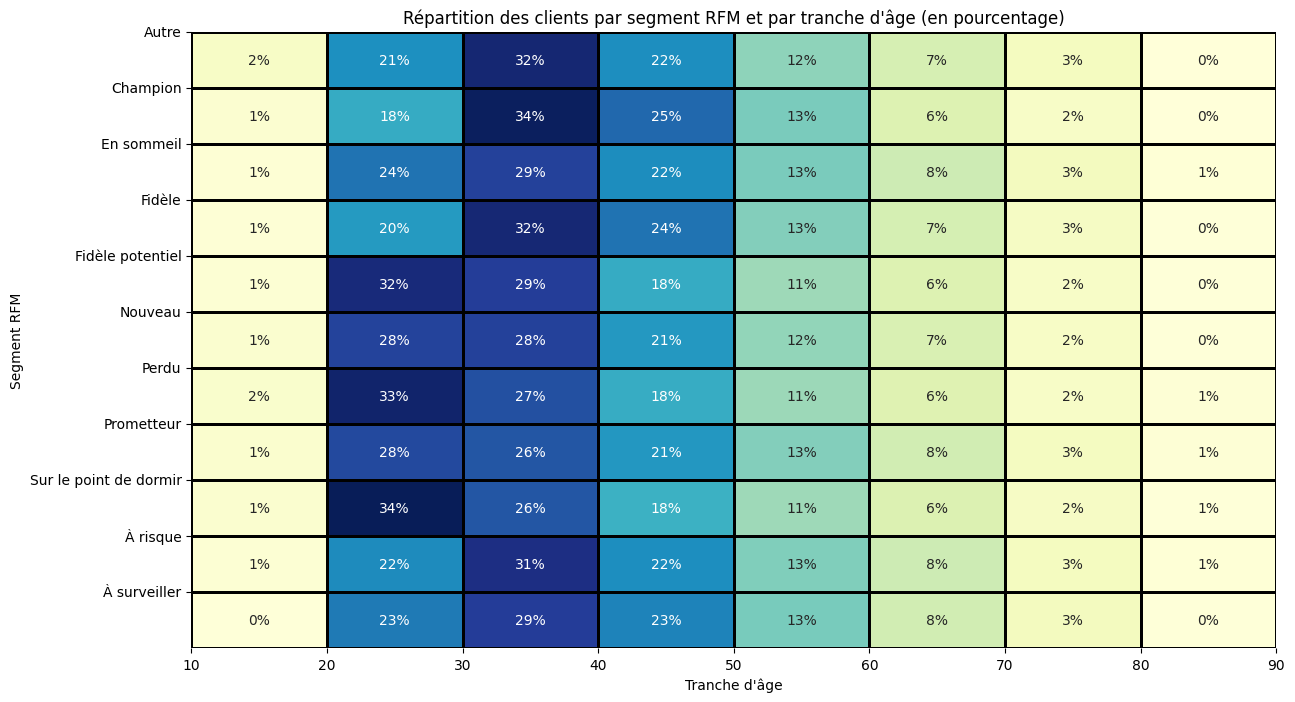

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que vous avez déjà un DataFrame pd_rfm_joined
# Vous pouvez le charger à partir d'une source de données ou d'un fichier CSV

# Créez une nouvelle colonne 'AgeGroup' pour regrouper les clients par tranches d'âge de 10 ans
pd_rfm_joined['AgeGroup'] = (pd_rfm_joined['age'] // 10) * 10

# Grouper les données par segment RFM et tranche d'âge, puis calculer les pourcentages en multipliant par 100
grouped_data = pd_rfm_joined.groupby(['segment_RFM', 'AgeGroup']).size().unstack().div(pd_rfm_joined.groupby('segment_RFM').size(), axis=0) * 100

# Récupérer les étiquettes des tranches d'âge
age_labels = [f'{i}' for i in range(10, 100, 10)]

# Ajouter le signe '%' aux annotations
annot_data = grouped_data.applymap(lambda x: f'{x:.0f}%')

# Afficher le tableau de répartition avec les pourcentages en pourcentage (%)
plt.figure(figsize=(14, 8))
sns.heatmap(grouped_data, annot=annot_data, cmap='YlGnBu', cbar=False, fmt='', linewidths=1, linecolor='black')
plt.title("Répartition des clients par segment RFM et par tranche d'âge (en pourcentage)")
plt.xlabel("Tranche d'âge")
plt.ylabel("Segment RFM")

# Déplacer les étiquettes des tranches d'âge au centre
plt.xticks(range(len(age_labels)), age_labels, rotation=0)

# Déplacer les étiquettes des tranches d'âge de 50 mm vers le bas
plt.yticks(range(len(grouped_data.index)), grouped_data.index, va="center")

plt.show()


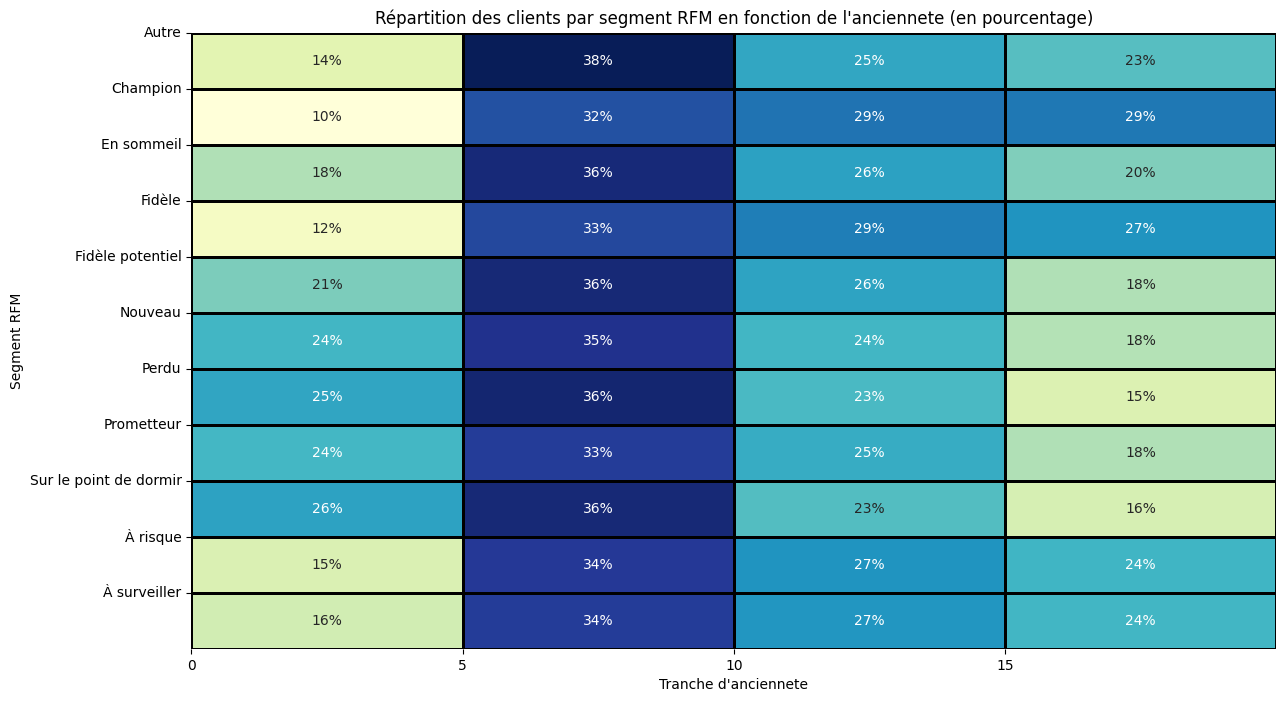

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supposons que vous avez déjà un DataFrame pd_rfm_joined
# Vous pouvez le charger à partir d'une source de données ou d'un fichier CSV

# Créez une nouvelle colonne 'AgeGroup' pour regrouper les clients par tranches d'âge de 10 ans
pd_rfm_joined['AgeGroup'] = (pd_rfm_joined['anciennete'] // 5) * 10

# Grouper les données par segment RFM et tranche d'âge, puis calculer les pourcentages en multipliant par 100
grouped_data = pd_rfm_joined.groupby(['segment_RFM', 'AgeGroup']).size().unstack().div(pd_rfm_joined.groupby('segment_RFM').size(), axis=0) * 100

# Récupérer les étiquettes des tranches d'âge
age_labels = [f'{i}' for i in range(0, 20, 5)]

# Ajouter le signe '%' aux annotations
annot_data = grouped_data.applymap(lambda x: f'{x:.0f}%')

# Afficher le tableau de répartition avec les pourcentages en pourcentage (%)
plt.figure(figsize=(14, 8))
sns.heatmap(grouped_data, annot=annot_data, cmap='YlGnBu', cbar=False, fmt='', linewidths=1, linecolor='black')
plt.title("Répartition des clients par segment RFM en fonction de l'anciennete (en pourcentage)")
plt.xlabel("Tranche d'anciennete")
plt.ylabel("Segment RFM")

# Déplacer les étiquettes des tranches d'âge au centre
plt.xticks(range(len(age_labels)), age_labels, rotation=0)

# Déplacer les étiquettes des tranches d'âge de 50 mm vers le bas
plt.yticks(range(len(grouped_data.index)), grouped_data.index, va="center")

plt.show()

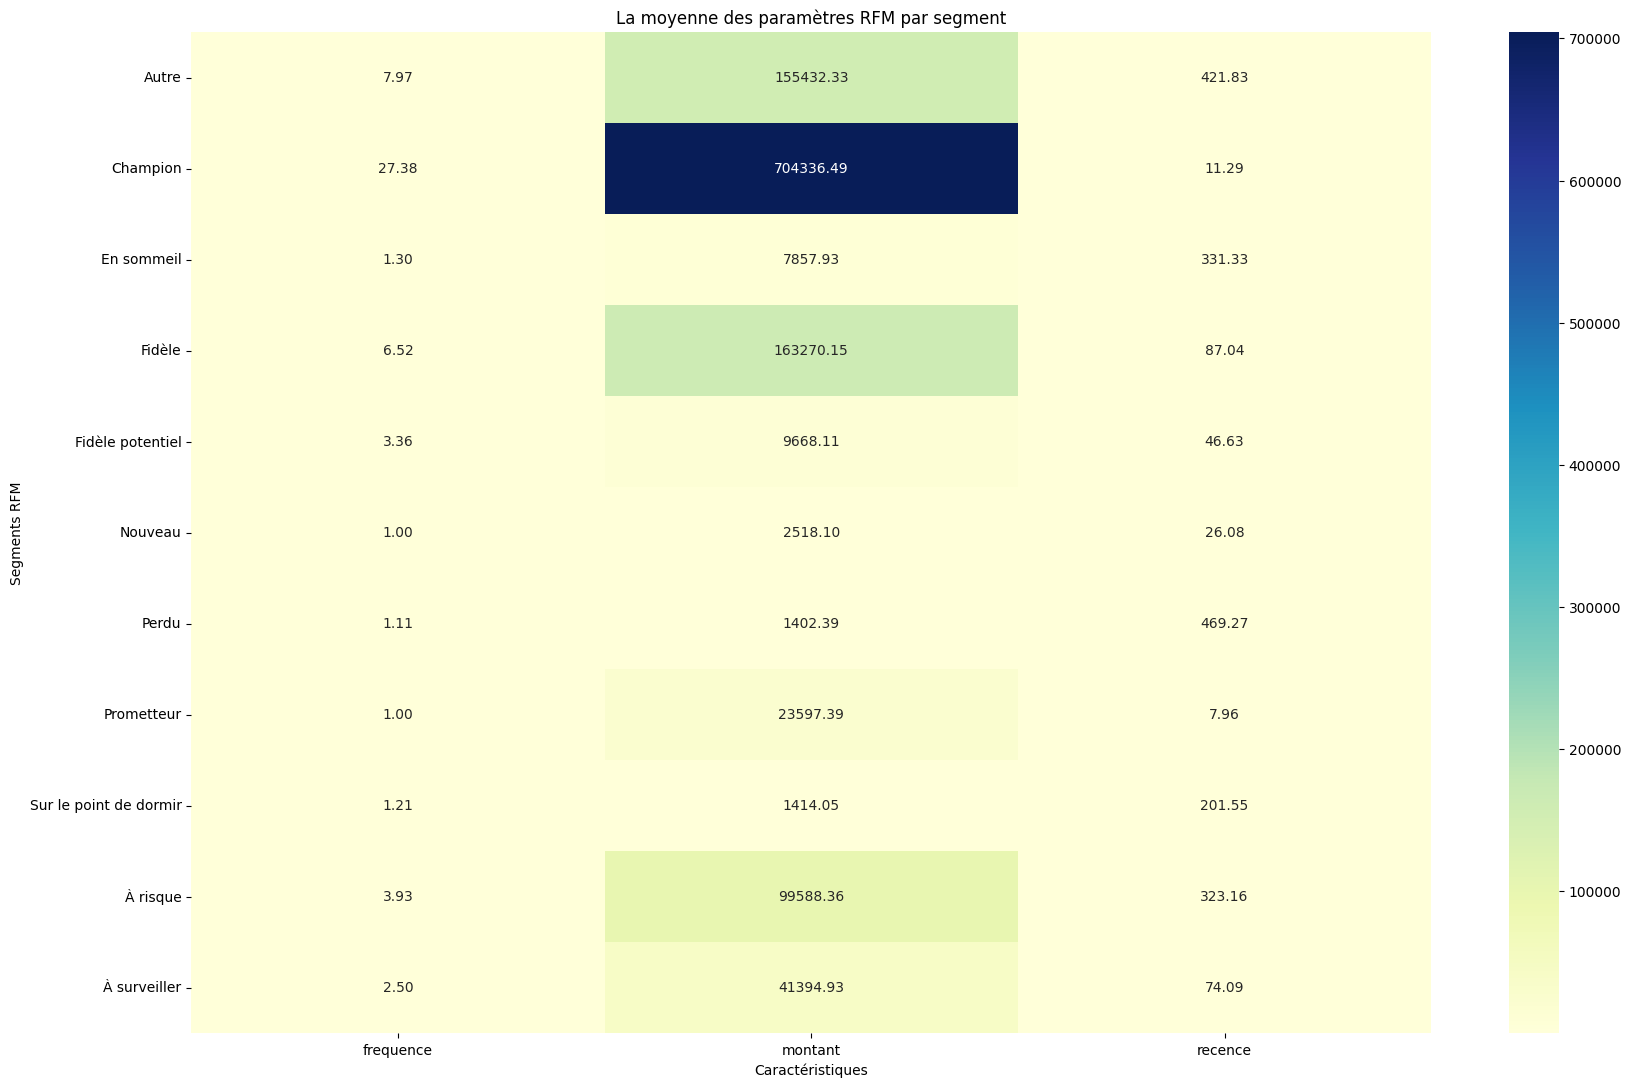

In [ ]:
import pandas as pd

# Supposons que vous avez un DataFrame "df" contenant les données

# Sélectionnez les colonnes pertinentes
selected_columns = ['recence', 'frequence', 'montant', 'segment_RFM']

# Créez un nouveau DataFrame contenant uniquement ces colonnes
df_selected = pd_rfm_segments[selected_columns]

# Utilisez la fonction pivot_table pour créer la matrice de correspondance
matrix = pd.pivot_table(df_selected, index='segment_RFM')
# Créez un heatmap pour représenter la matrice de passage
plt.figure(figsize=(20, 13))
sns.heatmap(matrix, annot=True, fmt=".2f", cmap="YlGnBu")

# Personnalisez le graphique
plt.title('La moyenne des paramètres RFM par segment')
plt.xlabel('Caractéristiques')
plt.ylabel('Segments RFM')

# Affichez le graphique
plt.show()



In [ ]:
# Visualization of correlation results with seaborn library pairplot
sns.pairplot(pd_rfm_segments, hue = "segment_RFM")

# **MODÉLISATION POUR LA SEGMENTATION VALEUR K-MEANS**

---



### Feature engineering

#### Sélection de variables

In [ ]:
taken_columns_km=['numero', 'anciennete', 'age', 'recence', 'frequence', 'avg_montant', 'palier_inf', 'palier_sup', 'nombre_services', 'nombre_canaux', 'Latest_avg_montant_recharge','montant/frequence selon mois']
to_take_columns_km=['transferts internationaux','nombre de villes','montant/frequence pour les services(financier/achat/paiement)' ,'taux de réponses aux promotions']
len(to_take_columns_km)

6

In [16]:
def df_km_create_sico(df_sico):
    taken_columns_sico = ['nd', 'date_naissance', 'date_debut_engagement', 'statut']
    df_km_sic = df_sico.select(taken_columns_sico) \
                    .filter(df_sico["statut"] == "ACTIF") \
                    .filter(df_sico["date_naissance"] != "NULL") \
                    .withColumnRenamed("nd", "numero") \
                    .drop("statut")
    df_km_sic = df_km_sic.withColumn("anciennete", year(current_date()) - year("date_debut_engagement")) \
                  .withColumn("age", year(current_date()) - year("date_naissance")).drop("date_naissance") \
                  .filter(col("age") > 10) \
                  .filter(col("age") < 100) \
                  .drop("date_debut_engagement")
    return df_km_sic

def df_km_create_transaction_aggregated(df_transaction):
    latest_date = to_date(lit("2023/08/17"), 'yyyy/MM/dd')
    df_km_transaction_aggregated1 = df_transaction.groupBy("numero") \
        .agg(datediff(latest_date, max(df_transaction["date"])).alias("recence"),
             count("*").alias("frequence_total"),
             sum(df_transaction["montant"].cast("double")).alias("montant_total"))
     #Nombre de destinataires
    df_km_transaction_aggregated2 = df_transaction.filter(col("type_service")=="Transfert").groupBy("numero").agg(countDistinct("destinataire").alias("nombre_destinataires"))
    df_km_transaction_aggregated=df_km_transaction_aggregated1.join(df_km_transaction_aggregated2,"numero","inner")
    return df_km_transaction_aggregated

def df_km_create_transaction_mois_montant(df_transaction):
   #Des colonnes de total pour chaque mois de 1 à 12
    df_km_transaction_mois = df_transaction
    for mois in range(1, 13):
        col_name = f"montant_mois{mois}"
        df_km_transaction_mois = df_km_transaction_mois.withColumn(col_name, when((df_km_transaction_mois["month"] == mois) & (df_km_transaction_mois["year"] == 2022), df_km_transaction_mois["montant"]).otherwise(0))
    df_km_transaction_mois_montant = df_km_transaction_mois.groupBy("numero").sum() \
                                             .drop("sum(montant)")
    for mois in range(1, 13):
        col_name =  f"montant_mois{mois}"
        df_km_transaction_mois_montant= df_km_transaction_mois_montant.withColumnRenamed(f"sum({col_name})", col_name)
    return df_km_transaction_mois_montant

def df_km_create_transaction_mois_freq(df_transaction):
    # Créez des colonnes de fréquence pour chaque mois de 1 à 12
    df_km_transaction_mois_freq = df_transaction
    for mois in range(1, 13):
        col_name =  f"frequence_mois{mois}"
        df_km_transaction_mois_freq = df_km_transaction_mois_freq.withColumn(col_name, when(df_km_transaction_mois_freq["month"] == mois, 1).otherwise(0))
    df_km_transaction_mois_freq = df_km_transaction_mois_freq.groupBy("numero").sum().drop("sum(montant)")
    for mois in range(1, 13):
        col_name =  f"frequence_mois{mois}"
        df_km_transaction_mois_freq= df_km_transaction_mois_freq.withColumnRenamed(f"sum({col_name})", col_name)
    return df_km_transaction_mois_freq


def df_km_create_segment_palier(df_segment_palier):
    #Integration des donnés de la segmentation palier
    taken_columns_palier=['msisdn','palier_inf','palier_sup']
    df_km_palier = df_segment_palier.select(taken_columns_palier) \
                  .withColumn("palier_inf", col("palier_inf").cast("double"))\
                  .withColumn("palier_sup", col("palier_sup").cast("double")) \
                  .withColumnRenamed("msisdn", "numero")
    return df_km_palier

def df_km_create_segment_multiservice(df_segment_multiservice):
    #Integration des donnés de la segmentation multiservice
    taken_columns_multiservice=["numero","nombre_services","nombre_canaux"]
    df_km_segment_multiservice=df_segment_multiservice.select(taken_columns_multiservice)
    return df_km_segment_multiservice


def df_km_create_segment_recharge(df_segment_recharge):
    #Intégration des données de la segmentation recharge
    max_year_df_km_recharge = df_segment_recharge.agg({"year": "max"}).collect()[0][0]
    max_month_df_km_recharge = df_segment_recharge.filter(col("year") == max_year_df_km_recharge)\
            .agg({"month": "max"}).collect()[0][0]
    df_km_latest_segment_recharge = df_segment_recharge.withColumnRenamed("msisdn","numero")\
                                  .withColumnRenamed("avg_montant_recharge","latest_avg_montant_recharge") \
                                  .filter((col("year") == max_year_df_km_recharge) & (col("month") == max_month_df_km_recharge)) \
                                  .select("numero","latest_avg_montant_recharge") \
                                  .withColumn("latest_avg_montant_recharge", col("latest_avg_montant_recharge").cast("double"))
    return df_km_latest_segment_recharge


def df_kmeans_create(df_sico, df_transaction, *dataframes_to_join):
    df_sic = df_km_create_sico(df_sico)
    df_km_created = df_sic

    for df_km_to_join in dataframes_to_join:
        df_km_created = df_km_created.join(df_km_to_join, "numero", "inner")
    return df_km_created

In [22]:
# Appel de la fonction df_kmeans_create avec les DataFrames en tant qu'arguments
df_kmeans_created = df_kmeans_create(
    df_sico,
    df_transaction_prepared,
    df_km_create_transaction_aggregated(df_transaction_prepared),
    df_km_create_segment_palier(df_segment_palier),
    df_km_create_segment_recharge(df_segment_recharge),
    df_km_create_segment_multiservice(df_segment_multiservice),
    df_km_create_transaction_mois_freq(df_transaction_prepared),
    df_km_create_transaction_mois_montant(df_transaction_prepared),
)


len(df_kmeans_created.columns)

pd_kmeans_created=df_kmeans_created.toPandas()

In [18]:
df_info(df_kmeans_created)

root
 |-- numero: string (nullable = true)
 |-- anciennete: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- recence: integer (nullable = true)
 |-- frequence_total: long (nullable = false)
 |-- montant_total: double (nullable = true)
 |-- nombre_destinataires: long (nullable = false)
 |-- palier_inf: double (nullable = true)
 |-- palier_sup: double (nullable = true)
 |-- latest_avg_montant_recharge: double (nullable = true)
 |-- nombre_services: integer (nullable = false)
 |-- nombre_canaux: integer (nullable = false)
 |-- frequence_mois1: long (nullable = true)
 |-- frequence_mois2: long (nullable = true)
 |-- frequence_mois3: long (nullable = true)
 |-- frequence_mois4: long (nullable = true)
 |-- frequence_mois5: long (nullable = true)
 |-- frequence_mois6: long (nullable = true)
 |-- frequence_mois7: long (nullable = true)
 |-- frequence_mois8: long (nullable = true)
 |-- frequence_mois9: long (nullable = true)
 |-- frequence_mois10: long (nullable = true)
 |-- f

#### Encodage des variables

In [ ]:
def df_kmeans_encode(df_to_encode:DataFrame, categorical_columns: list):
    #Encodage des variables catégorielles
    # Initialiser les étapes pour le pipeline
    df_to_encode=df_to_encode
    etapes = []

    # Appliquer StringIndexer pour l'encodage des étiquettes
    for col in categorical_columns:
        indexer = StringIndexer(inputCol=col, outputCol=col + "Index")
        etapes.append(indexer)

    # Créer un pipeline
    pipeline = Pipeline(stages=etapes)

    # Ajuster et transformer le DataFrame à l'aide du pipeline
    model = pipeline.fit(df_to_encode)
    df_encoded = model.transform(df_to_encode)
    return df_encoded

In [ ]:
df_kmeans_encoded=df_kmeans_encode(df_kmeans_created, categorical_columns=[])

### Feature columns


In [28]:
km_feature_columns =[  'anciennete', 'age', 'recence', 'frequence_total', 'montant_total', 'nombre_destinataires', 'palier_inf', 'palier_sup', 'latest_avg_montant_recharge', 'nombre_services', 'nombre_canaux', 'frequence_mois1', 'frequence_mois2', 'frequence_mois3', 'frequence_mois4', 'frequence_mois5', 'frequence_mois6', 'frequence_mois7', 'frequence_mois8', 'frequence_mois9', 'frequence_mois10', 'frequence_mois11', 'frequence_mois12', 'montant_mois1', 'montant_mois2', 'montant_mois3', 'montant_mois4', 'montant_mois5', 'montant_mois6', 'montant_mois7', 'montant_mois8', 'montant_mois9', 'montant_mois10', 'montant_mois11', 'montant_mois12']

### Nombre de clusters

In [ ]:
def elbow_method(df, feature_columns):
    # Assemble les caractéristiques en une seule colonne de vecteurs
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_kmeans = assembler.transform(df)

    # Essayer différentes valeurs de k et évaluer leur coût
    cost = []
    for k in range(2, 11):
        kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
        model = kmeans.fit(df_kmeans)
        cost.append(model.summary.trainingCost)

    # Tracé du coût en fonction du nombre de clusters (méthode du coude)
    plt.plot(range(2, 11), cost, marker='o')
    plt.xlabel('Nombre de clusters (k)')
    plt.ylabel('Coût')
    plt.title('Méthode du Coude pour le k optimal')
    plt.show()
elbow_method(df_kmeans_created, km_feature_columns)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

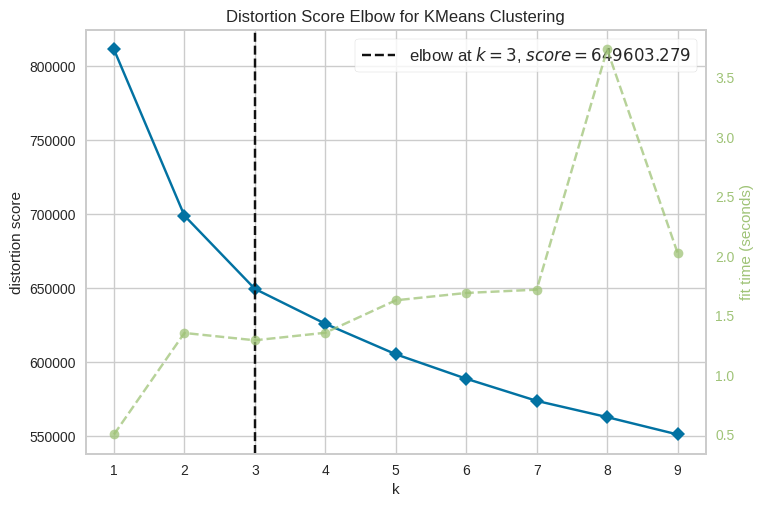

In [23]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from pyspark.sql import DataFrame

def visualize_elbow(pd_kmeans: DataFrame, feature_columns):
    # Sélectionner les colonnes RFM pour l'analyse

    kmeans_features = pd_kmeans[feature_columns]

    # Standardisation des caractéristiques
    scaler = StandardScaler()
    kmeans_features_scaled = scaler.fit_transform(kmeans_features)

    # Créer une instance du KElbowVisualizer
    visualizer = KElbowVisualizer(KMeans(random_state=42), k=(1, 10))

    # Ajuster le modèle et le visualizer
    visualizer.fit(kmeans_features_scaled)

    # Afficher le graphique
    visualizer.show()

# Exemple d'utilisation
visualize_elbow(pd_kmeans_created, km_feature_columns)

### Modèle 1

In [32]:
from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

def df_kmeans_model_train(df: DataFrame, optimal_k: int, feature_columns: list):
    # Assemble the features into a single vector column
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_kmeans = assembler.transform(df)

    # Initialize the K-Means model
    kmeans = KMeans().setK(optimal_k).setSeed(1).setFeaturesCol("features")

    # Fit the K-Means model to the data
    model = kmeans.fit(df_kmeans)

    # Effectue la transformation des données
    clustered_df = model.transform(df_kmeans)

    # Renomme la colonne "prediction" en "Cluster" et supprime la colonne "features"
    df_val_kmeans = clustered_df.withColumnRenamed("prediction", "cluster").drop("features")

    return df_val_kmeans


In [39]:
df_segment_valeur_kmeans = df_kmeans_model_train(df=df_kmeans_created, optimal_k=3,feature_columns=km_feature_columns )
# Convertir le DataFrame Spark en DataFrame Pandas
pd_segment_valeur_kmeans = df_segment_valeur_kmeans.toPandas()

In [34]:
df_segment_valeur_kmeans.printSchema()

root
 |-- numero: string (nullable = true)
 |-- anciennete: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- recence: integer (nullable = true)
 |-- frequence_total: long (nullable = false)
 |-- montant_total: double (nullable = true)
 |-- nombre_destinataires: long (nullable = false)
 |-- palier_inf: double (nullable = true)
 |-- palier_sup: double (nullable = true)
 |-- latest_avg_montant_recharge: double (nullable = true)
 |-- nombre_services: integer (nullable = false)
 |-- nombre_canaux: integer (nullable = false)
 |-- frequence_mois1: long (nullable = true)
 |-- frequence_mois2: long (nullable = true)
 |-- frequence_mois3: long (nullable = true)
 |-- frequence_mois4: long (nullable = true)
 |-- frequence_mois5: long (nullable = true)
 |-- frequence_mois6: long (nullable = true)
 |-- frequence_mois7: long (nullable = true)
 |-- frequence_mois8: long (nullable = true)
 |-- frequence_mois9: long (nullable = true)
 |-- frequence_mois10: long (nullable = true)
 |-- f

### Modèle 2

In [35]:
from pyspark.ml.clustering import KMeans
def df_kmeans_model_train_save(df, feature_columns: list,  optimal_k: int, model_path: str):

    # Assemble the features into a single vector column
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_kmeans = assembler.transform(df)

    # Initialize the K-Means model
    kmeans = KMeans().setK(optimal_k).setSeed(1).setFeaturesCol("features")

    # Fit the K-Means model to the data
    model = kmeans.fit(df_kmeans)

    # Save the K-Means model to the specified path
    model.write().overwrite().save(model_path)

    return model


In [36]:
def df_kmeans_model_load(df, feature_columns, model_path):

    # Assemble les caractéristiques en une seule colonne de vecteurs
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_kmeans = assembler.transform(df)

    # Charge le modèle K-Means sauvegardé
    model = KMeansModel.load(model_path)

    # Effectue la transformation des données
    clustered_df = model.transform(df_kmeans)

    # Renomme la colonne "prediction" en "Cluster" et supprime la colonne "features"
    clustered_df = clustered_df.withColumnRenamed("prediction", "Cluster").drop("features")

    return clustered_df


In [ ]:
feature_columns =[ 'anciennete', 'age', 'recence', 'frequence', 'avg_montant', 'palier_inf', 'palier_sup', 'nombre_services', 'nombre_canaux', 'latest_avg_montant_recharge']
model_path = "#models_OM/model_OM_Kmeans"  # Chemin de sauvegarde du modèle
optimal_k = 3  # Nombre optimal de clusters
df_kmeans_model_train_save(df_kmeans_created, km_feature_columns, optimal_k, model_path)

In [ ]:
df_kmeans_cluster = df_kmeans_model_load(df_kmeans_created, feature_columns, model_path)
pd_kmeans_cluster=df_kmeans_cluster.toPandas()
df_info(df_kmeans_cluster)

root
 |-- Numero: string (nullable = true)
 |-- Anciennete: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Recence: integer (nullable = true)
 |-- Frequence: long (nullable = false)
 |-- Avg_chiffre_affaire: double (nullable = true)
 |-- Palier_inf: double (nullable = true)
 |-- Palier_sup: double (nullable = true)
 |-- Nombre_services: integer (nullable = false)
 |-- Nombre_canaux: integer (nullable = false)
 |-- Latest_avg_montant_recharge: double (nullable = true)
 |-- Cluster: integer (nullable = false)

['Numero', 'Anciennete', 'Age', 'Recence', 'Frequence', 'Avg_chiffre_affaire', 'Palier_inf', 'Palier_sup', 'Nombre_services', 'Nombre_canaux', 'Latest_avg_montant_recharge', 'Cluster']

 
  Nombre de lignes : 53907, Nombre de colonnes : 12
+-------+----------+---+-------+---------+-------------------+----------+----------+---------------+-------------+---------------------------+-------+
|Numero |Anciennete|Age|Recence|Frequence|Avg_chiffre_affaire|Palier_inf|Pa

### Visualisation des segments K-Means

In [ ]:
# Définir la palette de couleurs
cluster_colors = ["green", "yellow", "red"]  # Vous pouvez personnaliser ces couleurs

# Créer le pairplot en utilisant la palette de couleurs
sns.set(style="ticks")
sns.pairplot(pd_segment_valeur_kmeans, hue="Cluster", palette=cluster_colors)

# Afficher le pairplot
plt.show()

In [ ]:
# Define the color palette
cluster_colors = ["green", "yellow", "red"]  # Customize these colors

# Create the pairplot using the color palette
sns.set(style="ticks")
pairplot = sns.pairplot(pd_segment_valeur_kmeans, hue="Cluster", palette=cluster_colors)

# Add an overall title to the pairplot
pairplot.fig.suptitle("Pairplot with Individual Subplot Titles", y=1.02)

# Add titles to each individual subplot
for i, ax in enumerate(pairplot.axes.flat):
    if i % (len(pd_segment_valeur_kmeans.columns) + 1) == 0:
        ax.set_title(pd_segment_valeur_kmeans.columns[i // (len(pd_segment_valeur_kmeans.columns) + 1)])

# Adjust the layout for the titles
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the pairplot
plt.show()


In [ ]:
pal = ['gold','#cc0000', '#ace600','#33cccc']
plt.figure(figsize=(13,8))
pl = sns.countplot(x=pd_segment_valeur_kmeans['Clusters'], palette= pal)
pl.set_title('Distribution Of The Clusters')
plt.show()

### Profilage des segments

In [ ]:
# df_kmeans =  (df_kmeans
#     .withColumn('Segment',
#         when(col('Cluster')==0, lit('Very High'))
#         .when(col('Cluster')==1, lit('High'))
#         .when(col('Cluster')==2, lit('Medium'))
#          .when(col('Cluster')==3, lit('Low'))
#         .otherwise(lit('Autre'))
#     )
# )

# df_kmeans.filter(col("Segment_service")=="Medium").show()

# **TESTS**

---



In [ ]:
# #Importation des CSV
# path='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'
# file_list=['2022_2.csv', '2022_3.csv','2022_4.csv','2022_5.csv','2022_6.csv','2022_7.csv',  '2022_8.csv', '2022_8.csv','2022_9.csv','2022_10.csv','2022_11.csv','2022_12.csv','2023_1.csv','2023_2.csv','2023_3.csv','2023_4.csv','2023_5.csv','2023_6.csv','2023_7.csv', ]
# df_agg = spark.read.csv(f'{path}/2022_1.csv', header=True)
# for csv_file in file_list:
#   df = spark.read.csv(f'{path}/{csv_file}', header=True, inferSchema=True)
#   df_agg = df_agg.union(df)

# df_agg.write.csv('#datasets_OM/trusted_om.base_transaction.csv', header=True, mode='overwrite')
# # df_agg.toPandas().to_csv('#datasets_OM/trusted_om.transactions.csv', index=False)
# # Show the RFM DataFrame
# df_agg.show()

In [ ]:
#!git clone https://github.com/asish012/dataanalytics.git